In [18]:
# Importing the required libraries for handling dataframes & graphs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression,  Lasso, Ridge,ElasticNet
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import zipfile
import os
import requests
import tempfile


In [19]:
# URL of the zip file on GitHub
zip_url = 'https://github.com/mredshaw/Credit_Approval_Prediction/raw/main/data/application_record.csv.zip'

# Create a temporary directory
with tempfile.TemporaryDirectory() as tmpdirname:
    zip_path = os.path.join(tmpdirname, 'application_record.zip')
    csv_path = os.path.join(tmpdirname, 'application_record.csv')

    # Download the zip file
    try:
        print(f"Downloading {zip_url}")
        r = requests.get(zip_url)
        r.raise_for_status()  # Raise an HTTPError for bad responses
        with open(zip_path, 'wb') as f:
            f.write(r.content)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        raise

    # Check if the zip file is downloaded correctly
    if os.path.exists(zip_path):
        print(f"Downloaded zip file is located at {zip_path}")
    else:
        print(f"Failed to download the zip file.")
        raise FileNotFoundError("Zip file not found after download")

    # Extract the zip file
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(tmpdirname)
            print(f"Extracted files: {zip_ref.namelist()}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting the zip file: {e}")
        raise

    # Check if the extracted CSV file exists
    if os.path.exists(csv_path):
        print(f"Extracted CSV file is located at {csv_path}")
    else:
        print(f"Failed to extract the CSV file.")
        raise FileNotFoundError("CSV file not found after extraction")

    # Load the datasets
    try:
        record = pd.read_csv('https://raw.githubusercontent.com/mredshaw/Credit_Approval_Prediction/main/data/credit_record.csv')
        df = pd.read_csv(csv_path)
        print(f"Successfully loaded datasets.")
    except FileNotFoundError as e:
        print(f"Error reading the CSV files: {e}")
        raise

# Now you can work with df and record


Downloaded zip file is located at /var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/tmprviklw4_/application_record.zip
Extracted files: ['application_record.csv', '__MACOSX/._application_record.csv']
Extracted CSV file is located at /var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/tmprviklw4_/application_record.csv
Successfully loaded datasets.


# Data Cleaning

In [20]:
df.set_index('ID', inplace=True)

In [21]:
df['OCCUPATION_TYPE'].fillna('undetermine', inplace=True)# fill NaN with undetermine

In [22]:
# Find index values of observations above 50000
drop_employ_outliers = df[df['DAYS_EMPLOYED']>50000].index

In [23]:
df.drop(drop_employ_outliers, inplace=True)

In [24]:
df[df['CNT_FAM_MEMBERS']>7].count()

CODE_GENDER            26
FLAG_OWN_CAR           26
FLAG_OWN_REALTY        26
CNT_CHILDREN           26
AMT_INCOME_TOTAL       26
NAME_INCOME_TYPE       26
NAME_EDUCATION_TYPE    26
NAME_FAMILY_STATUS     26
NAME_HOUSING_TYPE      26
DAYS_BIRTH             26
DAYS_EMPLOYED          26
FLAG_MOBIL             26
FLAG_WORK_PHONE        26
FLAG_PHONE             26
FLAG_EMAIL             26
OCCUPATION_TYPE        26
CNT_FAM_MEMBERS        26
dtype: int64

In [25]:
drop_fam_outliers = df[df['CNT_FAM_MEMBERS']>8].index
df.drop(drop_fam_outliers, inplace=True)

<Axes: ylabel='AMT_INCOME_TOTAL'>

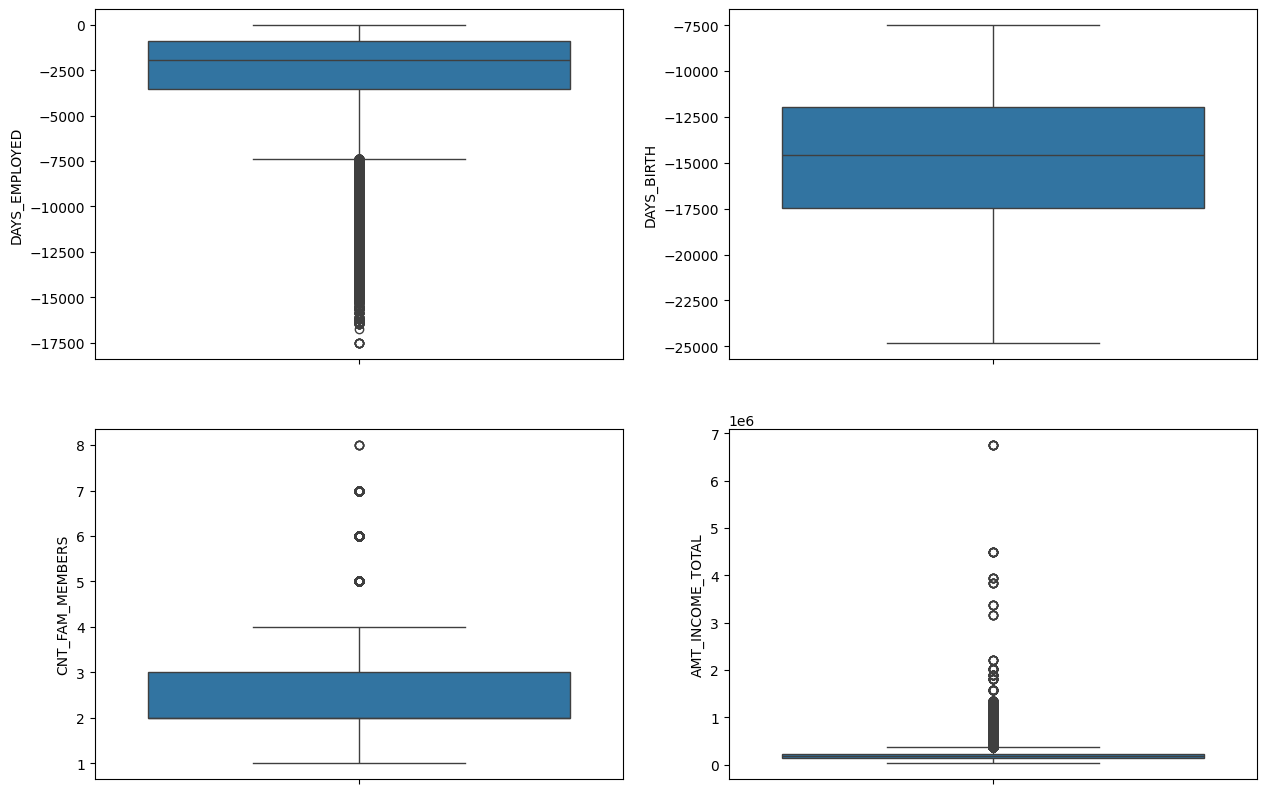

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(data=df, y='DAYS_EMPLOYED', ax=ax1)
sns.boxplot(data=df, y='DAYS_BIRTH', ax=ax2)
sns.boxplot(data=df, y='CNT_FAM_MEMBERS', ax=ax3)
sns.boxplot(data=df, y='AMT_INCOME_TOTAL', ax=ax4)

In [27]:
df[df['AMT_INCOME_TOTAL']>2000000]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,
5163386,M,Y,N,0,3825000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-18456,-1095,1,0,0,1,Managers,2.0
5163387,M,Y,N,0,3825000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-18456,-1095,1,0,0,1,Managers,2.0
5163388,M,Y,N,0,3825000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-18456,-1095,1,0,0,1,Managers,2.0
5163389,M,Y,N,0,3825000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-18456,-1095,1,0,0,1,Managers,2.0
5163390,M,Y,N,0,3825000.0,Commercial associate,Higher education,Civil marriage,House / apartment,-18456,-1095,1,0,0,1,Managers,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651834,M,Y,N,0,2025000.0,Working,Higher education,Married,House / apartment,-10887,-1515,1,1,1,0,Managers,2.0
6651835,M,Y,N,0,2025000.0,Working,Higher education,Married,House / apartment,-10887,-1515,1,1,1,0,Managers,2.0
7987964,M,Y,N,0,6750000.0,Working,Higher education,Married,House / apartment,-19341,-443,1,1,1,0,Laborers,2.0


In [28]:
drop_income_outliers = df[df['AMT_INCOME_TOTAL']>2000000].index
drop_income_outliers

Int64Index([5163386, 5163387, 5163388, 5163389, 5163390, 5584874, 5680511,
            5680512, 5680513, 5680514, 5680516, 5918977, 5873449, 5873450,
            5873451, 5873452, 6071071, 5987963, 5987964, 5987966, 5987967,
            5987968, 5987969, 5993384, 5993385, 5993386, 5993387, 5993388,
            5993389, 5993390, 5996392, 5996393, 5996394, 5996395, 5996396,
            5996403, 5996404, 5996405, 5996406, 5996407, 5996408, 5996409,
            5996410, 5996411, 5996412, 5996413, 6318664, 6318665, 6022090,
            6022091, 6022092, 6022093, 6123707, 6123708, 6123709, 6123710,
            6123713, 6123714, 6123715, 6272042, 6272043, 6272044, 6544043,
            6544044, 6544045, 6544046, 6544047, 6651834, 6651835, 7987964,
            7873452, 7996394],
           dtype='int64', name='ID')

In [29]:
df.drop(drop_income_outliers, inplace=True)

In [30]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,undetermine,2.0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,undetermine,2.0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [31]:
df['GENDER'] = df['CODE_GENDER'].map({'M':1, 'F':0})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'Y':1, 'N':0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'Y':1, 'N':0})

In [32]:
df['AGE'] = ((df['DAYS_BIRTH']/365)/ -1).astype(float).round(2)

In [33]:
df['YEARS_EMPLOYED'] = ((df['DAYS_EMPLOYED']/365)/ -1).astype(float).round(2)

In [34]:
df.describe()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,GENDER,AGE,YEARS_EMPLOYED
count,363119.000000,363119.000000,363119.000000,3.631190e+05,363119.000000,363119.000000,363119.0,363119.000000,363119.000000,363119.000000,363119.000000,363119.000000,363119.000000,363119.000000
mean,0.408326,0.679755,0.506933,1.939666e+05,-14811.752348,-2623.188665,1.0,0.248811,0.286639,0.118807,2.289916,0.364616,40.580150,7.186827
std,0.491525,0.466571,0.760328,1.032001e+05,3501.267259,2399.729717,0.0,0.432325,0.452192,0.323561,0.923785,0.481323,9.592497,6.574597
min,0.000000,0.000000,0.000000,2.700000e+04,-24834.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,20.520000,0.030000
25%,0.000000,0.000000,0.000000,1.350000e+05,-17454.000000,-3512.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,32.700000,2.510000
50%,0.000000,1.000000,0.000000,1.800000e+05,-14580.000000,-1924.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,39.950000,5.270000
75%,1.000000,1.000000,1.000000,2.250000e+05,-11937.000000,-915.000000,1.0,0.000000,1.000000,0.000000,3.000000,1.000000,47.820000,9.620000
max,1.000000,1.000000,6.000000,1.890000e+06,-7489.000000,-12.000000,1.0,1.000000,1.000000,1.000000,8.000000,1.000000,68.040000,48.030000


In [35]:
df['INCOME_PER_MEMBER'] = df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS']
df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL']/(df['CNT_CHILDREN']+1)

In [36]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD
ID,,,,,,,,,,,,,,,,,,,,,
5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,...,0,0,0,Security staff,2.0,1,58.83,3.11,56250.0,112500.0
5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0
5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0


In [37]:
df.reset_index()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,1,58.83,3.11,56250.0,112500.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363114,6839917,F,0,1,0,180000.0,Pensioner,Higher education,Married,House / apartment,...,0,0,0,undetermine,2.0,0,30.04,7.41,90000.0,180000.0
363115,6839936,M,1,1,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Laborers,3.0,1,34.44,5.74,45000.0,67500.0
363116,6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,Laborers,1.0,0,43.67,8.24,103500.0,103500.0
363117,6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,...,1,0,0,Sales staff,1.0,0,22.38,1.02,54000.0,54000.0


In [38]:
df.drop(['DAYS_EMPLOYED', 'DAYS_BIRTH'], axis=1, inplace= True)

In [39]:
print(df['NAME_HOUSING_TYPE'].unique())
print(df['NAME_FAMILY_STATUS'].unique())
print(df['NAME_EDUCATION_TYPE'].unique())
print(df['NAME_INCOME_TYPE'].unique())

['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']


In [40]:
df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD
ID,,,,,,,,,,,,,,,,,,,,
5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,1,58.83,3.11,56250.0,112500.0
5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0
5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0


In [41]:
record.drop_duplicates(inplace=True)

In [42]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [43]:
record['HISTORY_LENGTH'] = (record['MONTHS_BALANCE']/-1)+1

In [44]:
record['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [45]:
record['STATUS_VALUE'] = record['STATUS'].map({'5':0, 'X': 1,'C':2, '0':3, '1':4, '2':5, '3':6, '4':7}).astype(int)

In [46]:
record['STATUS_RISK'] = record['STATUS'].map({'X':0, 'C': 1,'0':2, '1':3, '2':4, '3':5, '4':6, '5':7}).astype(int)

In [47]:
record['DID_NOT_USE'] = (record['STATUS'] == 'X').astype(int)
record['PAID_ON_TIME'] = (record['STATUS'] == 'C').astype(int)
record['LATE_PAYMENT'] = (record['STATUS'].isin(['0','1', '2', '3', '4'])).astype(int)
record['EXTREME_LATE_PAYMENT'] = (record['STATUS'].isin([ '3', '4'])).astype(int)
record['DEFAULT'] = (record['STATUS'] == '5').astype(int)

In [48]:
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,DEFAULT
0,5001711,0,X,1.0,1,0,1,0,0,0,0
1,5001711,-1,0,2.0,3,2,0,0,1,0,0
2,5001711,-2,0,3.0,3,2,0,0,1,0,0
3,5001711,-3,0,4.0,3,2,0,0,1,0,0
4,5001712,0,C,1.0,2,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,1,0,0,0
1048571,5150487,-26,C,27.0,2,1,0,1,0,0,0
1048572,5150487,-27,C,28.0,2,1,0,1,0,0,0
1048573,5150487,-28,C,29.0,2,1,0,1,0,0,0


# Feature Engineering

- Using current variables to generate new variables for the model features
- Esp the Payment risk: use different variables to generate a variable best represent the default clients

In [49]:
bin_labels = [1, 2, 3, 4, 5]
record['HISTORY_VALUE'] = pd.qcut(record['HISTORY_LENGTH'], 5, labels=bin_labels, duplicates='drop')
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,DEFAULT,HISTORY_VALUE
0,5001711,0,X,1.0,1,0,1,0,0,0,0,1
1,5001711,-1,0,2.0,3,2,0,0,1,0,0,1
2,5001711,-2,0,3.0,3,2,0,0,1,0,0,1
3,5001711,-3,0,4.0,3,2,0,0,1,0,0,1
4,5001712,0,C,1.0,2,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,1,0,0,0,4
1048571,5150487,-26,C,27.0,2,1,0,1,0,0,0,4
1048572,5150487,-27,C,28.0,2,1,0,1,0,0,0,4
1048573,5150487,-28,C,29.0,2,1,0,1,0,0,0,4


In [50]:
grouped_mean = record.groupby('ID').agg({
    'STATUS_RISK': 'mean',
    'STATUS_VALUE': 'mean',
    'HISTORY_LENGTH': 'max',
    'DID_NOT_USE': 'sum',
    'PAID_ON_TIME': 'sum',
    'LATE_PAYMENT': 'sum',
    'EXTREME_LATE_PAYMENT': 'sum',
    'DEFAULT': 'sum'
}).reset_index()

In [51]:
grouped_mean.rename(columns={'DEFAULT': 'NUM_OF_DEFAULTS'}, inplace=True)

In [52]:
print(grouped_mean)

            ID  STATUS_RISK  STATUS_VALUE  HISTORY_LENGTH  DID_NOT_USE  \
0      5001711     1.500000      2.500000             4.0            1   
1      5001712     1.526316      2.526316            19.0            0   
2      5001713     0.000000      1.000000            22.0           22   
3      5001714     0.000000      1.000000            15.0           15   
4      5001715     0.000000      1.000000            60.0           60   
...        ...          ...           ...             ...          ...   
45980  5150482     1.666667      2.666667            29.0            0   
45981  5150483     0.000000      1.000000            18.0           18   
45982  5150484     1.923077      2.923077            13.0            0   
45983  5150485     2.000000      3.000000             2.0            0   
45984  5150487     1.000000      2.000000            30.0            0   

       PAID_ON_TIME  LATE_PAYMENT  EXTREME_LATE_PAYMENT  NUM_OF_DEFAULTS  
0                 0             3   

In [53]:
grouped_mean['DNU_RATIO'] = grouped_mean['DID_NOT_USE']/ grouped_mean['HISTORY_LENGTH']
grouped_mean['POT_RATIO'] = grouped_mean['PAID_ON_TIME']/ grouped_mean['HISTORY_LENGTH']
grouped_mean['LP_RATIO'] = grouped_mean['LATE_PAYMENT']/ grouped_mean['HISTORY_LENGTH']
grouped_mean['ELP_RATIO'] = grouped_mean['EXTREME_LATE_PAYMENT']/ grouped_mean['HISTORY_LENGTH']
grouped_mean['D_RATIO'] = grouped_mean['NUM_OF_DEFAULTS']/ grouped_mean['HISTORY_LENGTH']


In [54]:
grouped_mean['PAYMENT_RISK'] = ((grouped_mean['LP_RATIO']*0.1) + (grouped_mean['ELP_RATIO']*0.2) + (grouped_mean['D_RATIO']*0.7))*100

In [55]:
grouped_mean['PAYMENT_RISK'] = grouped_mean['PAYMENT_RISK'].round(0)

In [56]:
grouped_mean['PAYMENT_RISK'].describe()

count    45985.000000
mean         4.109688
std          3.753219
min          0.000000
25%          1.000000
50%          3.000000
75%          7.000000
max         63.000000
Name: PAYMENT_RISK, dtype: float64

In [57]:
grouped_mean.groupby('PAYMENT_RISK').count()

,ID,STATUS_RISK,STATUS_VALUE,HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,NUM_OF_DEFAULTS,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO
PAYMENT_RISK,,,,,,,,,,,,,,
0.0,7548,7548,7548,7548,7548,7548,7548,7548,7548,7548,7548,7548,7548,7548
1.0,6241,6241,6241,6241,6241,6241,6241,6241,6241,6241,6241,6241,6241,6241
2.0,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648,6648
3.0,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484
4.0,3478,3478,3478,3478,3478,3478,3478,3478,3478,3478,3478,3478,3478,3478
5.0,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021,3021
6.0,2336,2336,2336,2336,2336,2336,2336,2336,2336,2336,2336,2336,2336,2336
7.0,1816,1816,1816,1816,1816,1816,1816,1816,1816,1816,1816,1816,1816,1816
8.0,2074,2074,2074,2074,2074,2074,2074,2074,2074,2074,2074,2074,2074,2074


(array([3.3756e+04, 1.2087e+04, 4.6000e+01, 2.6000e+01, 2.5000e+01,
        1.1000e+01, 1.2000e+01, 7.0000e+00, 9.0000e+00, 6.0000e+00]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

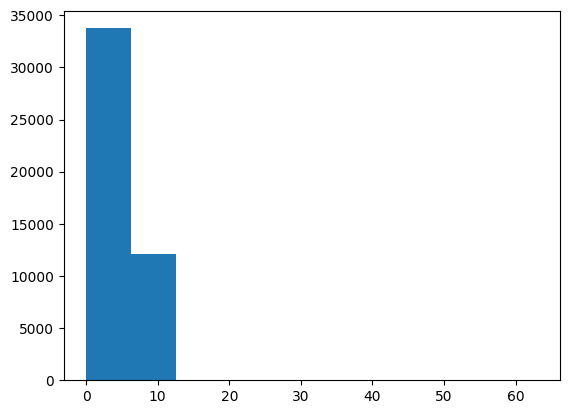

In [58]:
plt.hist(grouped_mean['PAYMENT_RISK'])

PAYMENT_RISK represents the defeaults pretty well

In [59]:
grouped_mean.groupby('PAYMENT_RISK')['NUM_OF_DEFAULTS'].describe()

,count,mean,std,min,25%,50%,75%,max
PAYMENT_RISK,,,,,,,,
0.0,7548.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
1.0,6241.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
2.0,6648.0,0.000301,0.017344,0.0,0.00,0.0,0.00,1.0
3.0,4484.0,0.000892,0.029857,0.0,0.00,0.0,0.00,1.0
4.0,3478.0,0.002300,0.067797,0.0,0.00,0.0,0.00,3.0
5.0,3021.0,0.000993,0.031502,0.0,0.00,0.0,0.00,1.0
6.0,2336.0,0.006421,0.118708,0.0,0.00,0.0,0.00,3.0
7.0,1816.0,0.011564,0.205646,0.0,0.00,0.0,0.00,5.0
8.0,2074.0,0.013018,0.197242,0.0,0.00,0.0,0.00,5.0


In [60]:
bins = [0, 2, 10, 20, 30, 40, 50, float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7']
grouped_mean['PAYMENT_RISK_LEVEL'] = pd.cut(grouped_mean['PAYMENT_RISK'], bins=bins, labels=labels, right=False)


/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_11197/3071349349.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['mean'], ci='sd', palette='viridis')
/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_11197/3071349349.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['mean'], ci='sd', palette='viridis')


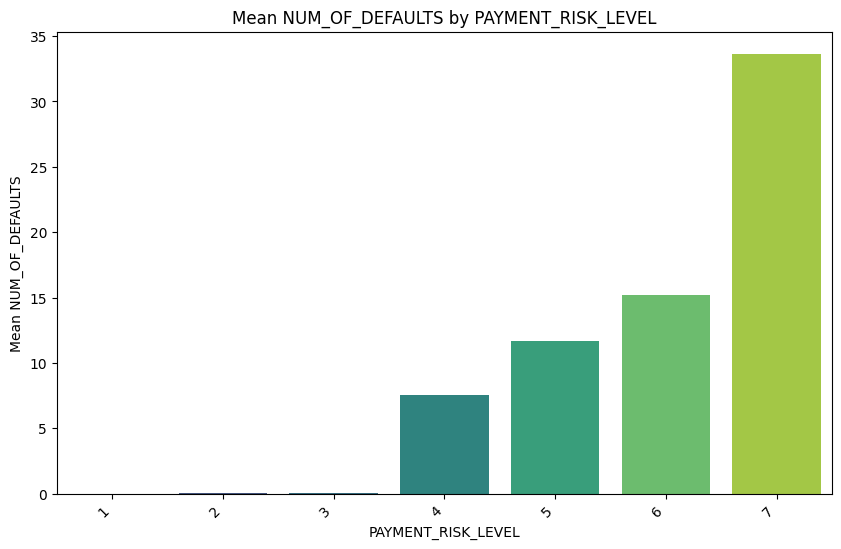

In [61]:
summary_stats = grouped_mean.groupby('PAYMENT_RISK_LEVEL')['NUM_OF_DEFAULTS'].describe()

plt.figure(figsize=(10, 6))
sns.barplot(x=summary_stats.index, y=summary_stats['mean'], ci='sd', palette='viridis')
plt.xlabel('PAYMENT_RISK_LEVEL')
plt.ylabel('Mean NUM_OF_DEFAULTS')
plt.title('Mean NUM_OF_DEFAULTS by PAYMENT_RISK_LEVEL')
plt.xticks(rotation=45, ha='right')
plt.show()

/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_11197/3026871552.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['mean'], ci='sd', palette='viridis')
/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_11197/3026871552.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_stats.index, y=summary_stats['mean'], ci='sd', palette='viridis')


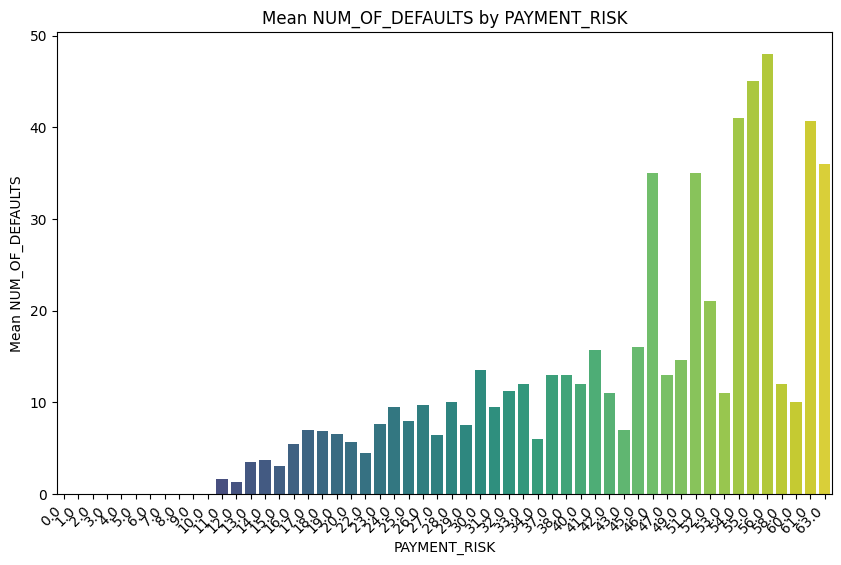

In [62]:
summary_stats = grouped_mean.groupby('PAYMENT_RISK')['NUM_OF_DEFAULTS'].describe()

plt.figure(figsize=(10, 6))
sns.barplot(x=summary_stats.index, y=summary_stats['mean'], ci='sd', palette='viridis')
plt.xlabel('PAYMENT_RISK')
plt.ylabel('Mean NUM_OF_DEFAULTS')
plt.title('Mean NUM_OF_DEFAULTS by PAYMENT_RISK')
plt.xticks(rotation=45, ha='right')
plt.show()

In [63]:
grouped_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    45985 non-null  int64   
 1   STATUS_RISK           45985 non-null  float64 
 2   STATUS_VALUE          45985 non-null  float64 
 3   HISTORY_LENGTH        45985 non-null  float64 
 4   DID_NOT_USE           45985 non-null  int64   
 5   PAID_ON_TIME          45985 non-null  int64   
 6   LATE_PAYMENT          45985 non-null  int64   
 7   EXTREME_LATE_PAYMENT  45985 non-null  int64   
 8   NUM_OF_DEFAULTS       45985 non-null  int64   
 9   DNU_RATIO             45985 non-null  float64 
 10  POT_RATIO             45985 non-null  float64 
 11  LP_RATIO              45985 non-null  float64 
 12  ELP_RATIO             45985 non-null  float64 
 13  D_RATIO               45985 non-null  float64 
 14  PAYMENT_RISK          45985 non-null  float64 
 15  PA

In [64]:
grouped_payment_risk = grouped_mean.groupby('PAYMENT_RISK_LEVEL').agg({
    'NUM_OF_DEFAULTS': 'sum',
    'EXTREME_LATE_PAYMENT' : 'sum',
    'LATE_PAYMENT':'sum',
    'PAID_ON_TIME':'sum',
    'DID_NOT_USE': 'sum'
}).reset_index()

In [65]:
grouped_payment_risk['COUNT'] = grouped_payment_risk['NUM_OF_DEFAULTS']+ grouped_payment_risk['EXTREME_LATE_PAYMENT'] + grouped_payment_risk['LATE_PAYMENT'] + grouped_payment_risk['PAID_ON_TIME'] + grouped_payment_risk['DID_NOT_USE']

In [66]:
grouped_payment_risk['DNU_RATIO'] = grouped_payment_risk['DID_NOT_USE']/ grouped_payment_risk['COUNT']
grouped_payment_risk['POT_RATIO'] = grouped_payment_risk['PAID_ON_TIME']/ grouped_payment_risk['COUNT']
grouped_payment_risk['LP_RATIO'] = grouped_payment_risk['LATE_PAYMENT']/ grouped_payment_risk['COUNT']
grouped_payment_risk['ELP_RATIO'] = grouped_payment_risk['EXTREME_LATE_PAYMENT']/ grouped_payment_risk['COUNT']
grouped_payment_risk['D_RATIO'] = grouped_payment_risk['NUM_OF_DEFAULTS']/ grouped_payment_risk['COUNT']

In [67]:
grouped_payment_risk.head(20)

,PAYMENT_RISK_LEVEL,NUM_OF_DEFAULTS,EXTREME_LATE_PAYMENT,LATE_PAYMENT,PAID_ON_TIME,DID_NOT_USE,COUNT,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO
0,1,0,3,26339,181288,140655,348285,0.403850,0.520516,0.075625,0.000009,0.000000
1,2,95,220,286269,259811,67400,613795,0.109809,0.423286,0.466392,0.000358,0.000155
2,3,303,161,82019,650,973,84106,0.011569,0.007728,0.975186,0.001914,0.003603
3,4,286,70,460,200,69,1085,0.063594,0.184332,0.423963,0.064516,0.263594
4,5,291,52,287,66,90,786,0.114504,0.083969,0.365140,0.066158,0.370229
5,6,213,23,131,16,11,394,0.027919,0.040609,0.332487,0.058376,0.540609
6,7,505,14,116,0,32,667,0.047976,0.000000,0.173913,0.020990,0.757121


In [68]:
client_history = record.groupby('ID').size().rename('NUM_OF_RECORDS').reset_index()

In [69]:
print(client_history)

            ID  NUM_OF_RECORDS
0      5001711               4
1      5001712              19
2      5001713              22
3      5001714              15
4      5001715              60
...        ...             ...
45980  5150482              18
45981  5150483              18
45982  5150484              13
45983  5150485               2
45984  5150487              30

[45985 rows x 2 columns]


In [70]:
grouped_mean = grouped_mean.merge(client_history, on='ID')

In [71]:
grouped_mean['NUM_OF_RECORDS'].describe()

count    45985.000000
mean        22.802544
std         15.492771
min          1.000000
25%         10.000000
50%         19.000000
75%         34.000000
max         61.000000
Name: NUM_OF_RECORDS, dtype: float64

In [72]:
grouped_mean

,ID,STATUS_RISK,STATUS_VALUE,HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,NUM_OF_DEFAULTS,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS
0,5001711,1.500000,2.500000,4.0,1,0,3,0,0,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4
1,5001712,1.526316,2.526316,19.0,0,9,10,0,0,0.00,0.473684,0.526316,0.0,0.0,5.0,2,19
2,5001713,0.000000,1.000000,22.0,22,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,22
3,5001714,0.000000,1.000000,15.0,15,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,15
4,5001715,0.000000,1.000000,60.0,60,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5150482,1.666667,2.666667,29.0,0,6,12,0,0,0.00,0.206897,0.413793,0.0,0.0,4.0,2,18
45981,5150483,0.000000,1.000000,18.0,18,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,18
45982,5150484,1.923077,2.923077,13.0,0,1,12,0,0,0.00,0.076923,0.923077,0.0,0.0,9.0,2,13
45983,5150485,2.000000,3.000000,2.0,0,0,2,0,0,0.00,0.000000,1.000000,0.0,0.0,10.0,3,2


In [73]:
bin_labels = [4, 3, 2, 1]
grouped_mean['HISTORY_RISK'] = pd.qcut(grouped_mean['HISTORY_LENGTH'], 4, labels=bin_labels, duplicates='drop')
grouped_mean['NUM_RECORD_RISK'] = pd.qcut(grouped_mean['NUM_OF_RECORDS'], 4, labels=bin_labels, duplicates='drop')

In [74]:
grouped_mean.describe()

,ID,STATUS_RISK,STATUS_VALUE,HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,NUM_OF_DEFAULTS,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,NUM_OF_RECORDS
count,4.598500e+04,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000,45985.000000
mean,5.070164e+06,1.283250,2.274123,27.433489,4.549962,9.612504,8.603262,0.011808,0.036816,0.184905,0.285447,0.402751,0.000406,0.001045,4.109688,22.802544
std,4.543364e+04,0.617532,0.598893,16.481280,9.622719,13.625156,8.451371,0.167529,0.855981,0.312397,0.340389,0.340159,0.006805,0.021345,3.753219,15.492771
min,5.001711e+06,0.000000,0.157895,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.026147e+06,1.045455,2.043478,13.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.114286,0.000000,0.000000,1.000000,10.000000
50%,5.065737e+06,1.314286,2.312500,26.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.023256,0.000000,0.305556,0.000000,0.000000,3.000000,19.000000
75%,5.114024e+06,1.750000,2.750000,41.000000,3.000000,16.000000,12.000000,0.000000,0.000000,0.200000,0.615385,0.666667,0.000000,0.000000,7.000000,34.000000
max,5.150487e+06,6.736842,4.200000,61.000000,61.000000,60.000000,61.000000,9.000000,48.000000,1.000000,1.000000,1.000000,0.400000,0.878049,63.000000,61.000000


In [75]:
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,DEFAULT,HISTORY_VALUE
0,5001711,0,X,1.0,1,0,1,0,0,0,0,1
1,5001711,-1,0,2.0,3,2,0,0,1,0,0,1
2,5001711,-2,0,3.0,3,2,0,0,1,0,0,1
3,5001711,-3,0,4.0,3,2,0,0,1,0,0,1
4,5001712,0,C,1.0,2,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,1,0,0,0,4
1048571,5150487,-26,C,27.0,2,1,0,1,0,0,0,4
1048572,5150487,-27,C,28.0,2,1,0,1,0,0,0,4
1048573,5150487,-28,C,29.0,2,1,0,1,0,0,0,4


In [76]:
record.head(5)

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,DEFAULT,HISTORY_VALUE
0,5001711,0,X,1.0,1,0,1,0,0,0,0,1
1,5001711,-1,0,2.0,3,2,0,0,1,0,0,1
2,5001711,-2,0,3.0,3,2,0,0,1,0,0,1
3,5001711,-3,0,4.0,3,2,0,0,1,0,0,1
4,5001712,0,C,1.0,2,1,0,1,0,0,0,1


In [77]:
grouped_mean.head(5)

,ID,STATUS_RISK,STATUS_VALUE,HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,NUM_OF_DEFAULTS,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK
0,5001711,1.500000,2.500000,4.0,1,0,3,0,0,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
1,5001712,1.526316,2.526316,19.0,0,9,10,0,0,0.00,0.473684,0.526316,0.0,0.0,5.0,2,19,3,3
2,5001713,0.000000,1.000000,22.0,22,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,22,3,2
3,5001714,0.000000,1.000000,15.0,15,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,15,3,3
4,5001715,0.000000,1.000000,60.0,60,0,0,0,0,1.00,0.000000,0.000000,0.0,0.0,0.0,1,60,1,1


In [78]:
record.drop(columns={'DID_NOT_USE', 'PAID_ON_TIME', 'LATE_PAYMENT', 'EXTREME_LATE_PAYMENT'}, inplace=True)

In [79]:
grouped_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45985 entries, 0 to 45984
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    45985 non-null  int64   
 1   STATUS_RISK           45985 non-null  float64 
 2   STATUS_VALUE          45985 non-null  float64 
 3   HISTORY_LENGTH        45985 non-null  float64 
 4   DID_NOT_USE           45985 non-null  int64   
 5   PAID_ON_TIME          45985 non-null  int64   
 6   LATE_PAYMENT          45985 non-null  int64   
 7   EXTREME_LATE_PAYMENT  45985 non-null  int64   
 8   NUM_OF_DEFAULTS       45985 non-null  int64   
 9   DNU_RATIO             45985 non-null  float64 
 10  POT_RATIO             45985 non-null  float64 
 11  LP_RATIO              45985 non-null  float64 
 12  ELP_RATIO             45985 non-null  float64 
 13  D_RATIO               45985 non-null  float64 
 14  PAYMENT_RISK          45985 non-null  float64 
 15  PA

In [80]:
record = record.merge(grouped_mean, on='ID')

In [81]:
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH_x,STATUS_VALUE_x,STATUS_RISK_x,DEFAULT,HISTORY_VALUE,STATUS_RISK_y,STATUS_VALUE_y,...,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK
0,5001711,0,X,1.0,1,0,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
1,5001711,-1,0,2.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
2,5001711,-2,0,3.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
3,5001711,-3,0,4.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
4,5001712,0,C,1.0,2,1,0,1,1.526316,2.526316,...,0.00,0.473684,0.526316,0.0,0.0,5.0,2,19,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048571,5150487,-26,C,27.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048572,5150487,-27,C,28.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048573,5150487,-28,C,29.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2


In [82]:
record['PAYMENT_RISK_LEVEL'].unique()

['2', '1', '3', '6', '5', '4', '7']
Categories (7, object): ['1' < '2' < '3' < '4' < '5' < '6' < '7']

In [83]:
grouped_mean['PAYMENT_RISK_LEVEL'].unique()

['2', '1', '3', '6', '5', '4', '7']
Categories (7, object): ['1' < '2' < '3' < '4' < '5' < '6' < '7']

In [84]:
record.rename(columns={'STATUS_RISK_y': 'CUST_STATUS_RISK', 'STATUS_VALUE_y': 'CUST_VALUE', 'STATUS_VALUE_x':'STATUS_VALUE','STATUS_RISK_x':'STATUS_RISK', 'HISTORY_LENGTH_x': 'HISTORY_LENGTH','HISTORY_LENGTH_y': 'TOTAL_HISTORY_LENGTH'}, inplace=True)
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK
0,5001711,0,X,1.0,1,0,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
1,5001711,-1,0,2.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
2,5001711,-2,0,3.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
3,5001711,-3,0,4.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
4,5001712,0,C,1.0,2,1,0,1,1.526316,2.526316,...,0.00,0.473684,0.526316,0.0,0.0,5.0,2,19,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048571,5150487,-26,C,27.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048572,5150487,-27,C,28.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048573,5150487,-28,C,29.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2


In [85]:
bin_labels = [1, 2, 3, 4, 5]
record['HISTORY_VALUE'] = pd.qcut(record['HISTORY_LENGTH'], 5, labels=bin_labels, duplicates='drop')
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK
0,5001711,0,X,1.0,1,0,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
1,5001711,-1,0,2.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
2,5001711,-2,0,3.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
3,5001711,-3,0,4.0,3,2,0,1,1.500000,2.500000,...,0.25,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4
4,5001712,0,C,1.0,2,1,0,1,1.526316,2.526316,...,0.00,0.473684,0.526316,0.0,0.0,5.0,2,19,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048571,5150487,-26,C,27.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048572,5150487,-27,C,28.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2
1048573,5150487,-28,C,29.0,2,1,0,4,1.000000,2.000000,...,0.00,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2


In [86]:
record[record['HISTORY_VALUE']>3]

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,DNU_RATIO,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK
82,5001715,-22,X,23.0,1,0,0,4,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,60,1,1
83,5001715,-23,X,24.0,1,0,0,4,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,60,1,1
84,5001715,-24,X,25.0,1,0,0,4,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,60,1,1
85,5001715,-25,X,26.0,1,0,0,4,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,60,1,1
86,5001715,-26,X,27.0,1,0,0,4,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,60,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,4,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,30,2,2
1048571,5150487,-26,C,27.0,2,1,0,4,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,30,2,2
1048572,5150487,-27,C,28.0,2,1,0,4,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,30,2,2
1048573,5150487,-28,C,29.0,2,1,0,4,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,30,2,2


In [87]:
record['CUST_VALUE'] = pd.to_numeric(record['CUST_VALUE'], errors='coerce')
record['HISTORY_VALUE'] = pd.to_numeric(record['HISTORY_VALUE'], errors='coerce')
record['CUST_STATUS_RISK'] = pd.to_numeric(record['CUST_STATUS_RISK'], errors='coerce')
record['HISTORY_RISK'] = pd.to_numeric(record['HISTORY_RISK'], errors='coerce')
record['NUM_RECORD_RISK'] = pd.to_numeric(record['NUM_RECORD_RISK'], errors='coerce')
record['PAYMENT_RISK_LEVEL'] = pd.to_numeric(record['PAYMENT_RISK_LEVEL'], errors='coerce')

In [88]:
record['CUST_SCORE'] = (record['CUST_VALUE']+record['HISTORY_VALUE']) - (record['CUST_STATUS_RISK'] + record['HISTORY_RISK'])

In [89]:
record

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK,CUST_SCORE
0,5001711,0,X,1.0,1,0,0,1,1.500000,2.500000,...,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0
1,5001711,-1,0,2.0,3,2,0,1,1.500000,2.500000,...,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0
2,5001711,-2,0,3.0,3,2,0,1,1.500000,2.500000,...,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0
3,5001711,-3,0,4.0,3,2,0,1,1.500000,2.500000,...,0.000000,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0
4,5001712,0,C,1.0,2,1,0,1,1.526316,2.526316,...,0.473684,0.526316,0.0,0.0,5.0,2,19,3,3,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,C,26.0,2,1,0,4,1.000000,2.000000,...,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2,3.0
1048571,5150487,-26,C,27.0,2,1,0,4,1.000000,2.000000,...,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2,3.0
1048572,5150487,-27,C,28.0,2,1,0,4,1.000000,2.000000,...,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2,3.0
1048573,5150487,-28,C,29.0,2,1,0,4,1.000000,2.000000,...,1.000000,0.000000,0.0,0.0,0.0,1,30,2,2,3.0


In [90]:
record[record['STATUS']==5]

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK,CUST_SCORE


In [91]:
record[record['STATUS']=='2']

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,POT_RATIO,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK,CUST_SCORE
8911,5002126,-46,2,47.0,5,4,0,5,1.339286,2.339286,...,0.821429,0.142857,0.035714,0.000000,2.0,2,56,1,1,5.00000
8914,5002126,-49,2,50.0,5,4,0,5,1.339286,2.339286,...,0.821429,0.142857,0.035714,0.000000,2.0,2,56,1,1,5.00000
8915,5002126,-50,2,51.0,5,4,0,5,1.339286,2.339286,...,0.821429,0.142857,0.035714,0.000000,2.0,2,56,1,1,5.00000
11778,5002255,-4,2,5.0,5,4,0,1,2.105263,3.105263,...,0.000000,0.973684,0.000000,0.000000,10.0,3,38,2,1,0.00000
12370,5002283,-48,2,49.0,5,4,0,5,1.344262,2.344262,...,0.672131,0.311475,0.000000,0.000000,3.0,2,61,1,1,5.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041047,5149838,-23,2,24.0,5,4,0,4,3.181818,2.484848,...,0.424242,0.363636,0.060606,0.212121,20.0,4,33,2,2,1.30303
1041048,5149838,-24,2,25.0,5,4,0,4,3.181818,2.484848,...,0.424242,0.363636,0.060606,0.212121,20.0,4,33,2,2,1.30303
1044484,5150049,0,2,1.0,5,4,0,1,2.300000,3.300000,...,0.000000,1.000000,0.000000,0.000000,10.0,3,10,4,4,-2.00000
1046235,5150238,-5,2,6.0,5,4,0,1,0.481481,1.481481,...,0.000000,0.203704,0.000000,0.000000,2.0,2,54,1,1,1.00000


In [92]:
record['DEFAULT'].describe()

count    1.048575e+06
mean     1.614572e-03
std      4.014931e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: DEFAULT, dtype: float64

In [93]:
record_grouped = record.groupby('ID')
print(record_grouped)

In [94]:
df.reset_index(inplace=True)

In [95]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,1,58.83,3.11,56250.0,112500.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0


In [96]:
df.drop_duplicates(inplace=True)

In [97]:
record.drop_duplicates(inplace=True)

In [98]:
record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 27 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1048575 non-null  int64  
 1   MONTHS_BALANCE        1048575 non-null  int64  
 2   STATUS                1048575 non-null  object 
 3   HISTORY_LENGTH        1048575 non-null  float64
 4   STATUS_VALUE          1048575 non-null  int64  
 5   STATUS_RISK           1048575 non-null  int64  
 6   DEFAULT               1048575 non-null  int64  
 7   HISTORY_VALUE         1048575 non-null  int64  
 8   CUST_STATUS_RISK      1048575 non-null  float64
 9   CUST_VALUE            1048575 non-null  float64
 10  TOTAL_HISTORY_LENGTH  1048575 non-null  float64
 11  DID_NOT_USE           1048575 non-null  int64  
 12  PAID_ON_TIME          1048575 non-null  int64  
 13  LATE_PAYMENT          1048575 non-null  int64  
 14  EXTREME_LATE_PAYMENT  1048575 non-

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363119 entries, 0 to 363118
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   363119 non-null  int64  
 1   CODE_GENDER          363119 non-null  object 
 2   FLAG_OWN_CAR         363119 non-null  int64  
 3   FLAG_OWN_REALTY      363119 non-null  int64  
 4   CNT_CHILDREN         363119 non-null  int64  
 5   AMT_INCOME_TOTAL     363119 non-null  float64
 6   NAME_INCOME_TYPE     363119 non-null  object 
 7   NAME_EDUCATION_TYPE  363119 non-null  object 
 8   NAME_FAMILY_STATUS   363119 non-null  object 
 9   NAME_HOUSING_TYPE    363119 non-null  object 
 10  FLAG_MOBIL           363119 non-null  int64  
 11  FLAG_WORK_PHONE      363119 non-null  int64  
 12  FLAG_PHONE           363119 non-null  int64  
 13  FLAG_EMAIL           363119 non-null  int64  
 14  OCCUPATION_TYPE      363119 non-null  object 
 15  CNT_FAM_MEMBERS  

In [100]:
status_map = {'X': 1, 'C':2, '0':3,'1':4, '2':5, '3':6, '4':7, '5':8}

In [101]:
record['STATUS_NUM'] = record['STATUS'].map(status_map)

In [102]:
record.head()

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK,CUST_SCORE,STATUS_NUM
0,5001711,0,X,1.0,1,0,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,1
1,5001711,-1,0,2.0,3,2,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,3
2,5001711,-2,0,3.0,3,2,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,3
3,5001711,-3,0,4.0,3,2,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,3
4,5001712,0,C,1.0,2,1,0,1,1.526316,2.526316,...,0.526316,0.0,0.0,5.0,2,19,3,3,-1.0,2


In [103]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,undetermine,2.0,1,32.89,12.44,213750.0,427500.0
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,Security staff,2.0,1,58.83,3.11,56250.0,112500.0
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,Sales staff,1.0,0,52.36,8.36,270000.0,270000.0


In [104]:
df['INCOME_TYPE'] = df['NAME_INCOME_TYPE'].astype('category').cat.codes
df['EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].astype('category').cat.codes
df['FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].astype('category').cat.codes
df['HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].astype('category').cat.codes
df['OCCUPATION_NUM'] = df['OCCUPATION_TYPE'].astype('category').cat.codes

In [105]:
df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
GENDER                   int64
AGE                    float64
YEARS_EMPLOYED         float64
INCOME_PER_MEMBER      float64
INCOME_PER_CHILD       float64
INCOME_TYPE               int8
EDUCATION_TYPE            int8
FAMILY_STATUS             int8
HOUSING_TYPE              int8
OCCUPATION_NUM            int8
dtype: object

In [106]:
record['PAYMENT_RISK_LEVEL'].unique

<bound method Series.unique of 0          2
1          2
2          2
3          2
4          2
          ..
1048570    1
1048571    1
1048572    1
1048573    1
1048574    1
Name: PAYMENT_RISK_LEVEL, Length: 1048575, dtype: int64>

In [107]:
record.head()

,ID,MONTHS_BALANCE,STATUS,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,...,LP_RATIO,ELP_RATIO,D_RATIO,PAYMENT_RISK,PAYMENT_RISK_LEVEL,NUM_OF_RECORDS,HISTORY_RISK,NUM_RECORD_RISK,CUST_SCORE,STATUS_NUM
0,5001711,0,X,1.0,1,0,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,1
1,5001711,-1,0,2.0,3,2,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,3
2,5001711,-2,0,3.0,3,2,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,3
3,5001711,-3,0,4.0,3,2,0,1,1.500000,2.500000,...,0.750000,0.0,0.0,8.0,2,4,4,4,-2.0,3
4,5001712,0,C,1.0,2,1,0,1,1.526316,2.526316,...,0.526316,0.0,0.0,5.0,2,19,3,3,-1.0,2


In [108]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM
0,5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
1,5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
2,5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,58.83,3.11,56250.0,112500.0,4,4,1,1,16
3,5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,52.36,8.36,270000.0,270000.0,0,4,3,1,14
4,5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,52.36,8.36,270000.0,270000.0,0,4,3,1,14


In [109]:
#Merge two datasets
df_merged=pd.merge(record, df, how='inner', on=['ID'])

In [110]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649580 entries, 0 to 649579
Data columns (total 53 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    649580 non-null  int64  
 1   MONTHS_BALANCE        649580 non-null  int64  
 2   STATUS                649580 non-null  object 
 3   HISTORY_LENGTH        649580 non-null  float64
 4   STATUS_VALUE          649580 non-null  int64  
 5   STATUS_RISK           649580 non-null  int64  
 6   DEFAULT               649580 non-null  int64  
 7   HISTORY_VALUE         649580 non-null  int64  
 8   CUST_STATUS_RISK      649580 non-null  float64
 9   CUST_VALUE            649580 non-null  float64
 10  TOTAL_HISTORY_LENGTH  649580 non-null  float64
 11  DID_NOT_USE           649580 non-null  int64  
 12  PAID_ON_TIME          649580 non-null  int64  
 13  LATE_PAYMENT          649580 non-null  int64  
 14  EXTREME_LATE_PAYMENT  649580 non-null  int64  
 15  

In [111]:
df_merged.drop(['STATUS', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'], axis=1, inplace=True)

In [112]:
df_merged['PAYMENT_RISK_LEVEL'].unique()

array([1, 2, 3, 5, 4, 7, 6])

In [113]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649580 entries, 0 to 649579
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    649580 non-null  int64  
 1   MONTHS_BALANCE        649580 non-null  int64  
 2   HISTORY_LENGTH        649580 non-null  float64
 3   STATUS_VALUE          649580 non-null  int64  
 4   STATUS_RISK           649580 non-null  int64  
 5   DEFAULT               649580 non-null  int64  
 6   HISTORY_VALUE         649580 non-null  int64  
 7   CUST_STATUS_RISK      649580 non-null  float64
 8   CUST_VALUE            649580 non-null  float64
 9   TOTAL_HISTORY_LENGTH  649580 non-null  float64
 10  DID_NOT_USE           649580 non-null  int64  
 11  PAID_ON_TIME          649580 non-null  int64  
 12  LATE_PAYMENT          649580 non-null  int64  
 13  EXTREME_LATE_PAYMENT  649580 non-null  int64  
 14  NUM_OF_DEFAULTS       649580 non-null  int64  
 15  

In [114]:
df_merged[df_merged['DEFAULT']==1]

,ID,MONTHS_BALANCE,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,...,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM
12239,5009628,-32,33.0,0,7,1,4,2.083333,2.550000,60.0,...,0,52.89,9.03,119250.0,238500.0,4,4,1,1,8
12240,5009628,-33,34.0,0,7,1,5,2.083333,2.550000,60.0,...,0,52.89,9.03,119250.0,238500.0,4,4,1,1,8
12241,5009628,-34,35.0,0,7,1,5,2.083333,2.550000,60.0,...,0,52.89,9.03,119250.0,238500.0,4,4,1,1,8
12242,5009628,-35,36.0,0,7,1,5,2.083333,2.550000,60.0,...,0,52.89,9.03,119250.0,238500.0,4,4,1,1,8
13580,5009744,0,1.0,0,7,1,1,5.050000,2.850000,20.0,...,0,37.14,1.61,157500.0,315000.0,0,1,1,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643383,5149838,-16,17.0,0,7,1,3,3.181818,2.484848,33.0,...,0,33.94,3.63,78750.0,157500.0,1,1,1,1,11
643384,5149838,-17,18.0,0,7,1,3,3.181818,2.484848,33.0,...,0,33.94,3.63,78750.0,157500.0,1,1,1,1,11
643385,5149838,-18,19.0,0,7,1,3,3.181818,2.484848,33.0,...,0,33.94,3.63,78750.0,157500.0,1,1,1,1,11
643386,5149838,-19,20.0,0,7,1,3,3.181818,2.484848,33.0,...,0,33.94,3.63,78750.0,157500.0,1,1,1,1,11


In [115]:
df_merged.dtypes

ID                        int64
MONTHS_BALANCE            int64
HISTORY_LENGTH          float64
STATUS_VALUE              int64
STATUS_RISK               int64
DEFAULT                   int64
HISTORY_VALUE             int64
CUST_STATUS_RISK        float64
CUST_VALUE              float64
TOTAL_HISTORY_LENGTH    float64
DID_NOT_USE               int64
PAID_ON_TIME              int64
LATE_PAYMENT              int64
EXTREME_LATE_PAYMENT      int64
NUM_OF_DEFAULTS           int64
DNU_RATIO               float64
POT_RATIO               float64
LP_RATIO                float64
ELP_RATIO               float64
D_RATIO                 float64
PAYMENT_RISK            float64
PAYMENT_RISK_LEVEL        int64
NUM_OF_RECORDS            int64
HISTORY_RISK              int64
NUM_RECORD_RISK           int64
CUST_SCORE              float64
STATUS_NUM                int64
FLAG_OWN_CAR              int64
FLAG_OWN_REALTY           int64
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
FLAG_MOB

In [116]:
df_merged.dtypes

ID                        int64
MONTHS_BALANCE            int64
HISTORY_LENGTH          float64
STATUS_VALUE              int64
STATUS_RISK               int64
DEFAULT                   int64
HISTORY_VALUE             int64
CUST_STATUS_RISK        float64
CUST_VALUE              float64
TOTAL_HISTORY_LENGTH    float64
DID_NOT_USE               int64
PAID_ON_TIME              int64
LATE_PAYMENT              int64
EXTREME_LATE_PAYMENT      int64
NUM_OF_DEFAULTS           int64
DNU_RATIO               float64
POT_RATIO               float64
LP_RATIO                float64
ELP_RATIO               float64
D_RATIO                 float64
PAYMENT_RISK            float64
PAYMENT_RISK_LEVEL        int64
NUM_OF_RECORDS            int64
HISTORY_RISK              int64
NUM_RECORD_RISK           int64
CUST_SCORE              float64
STATUS_NUM                int64
FLAG_OWN_CAR              int64
FLAG_OWN_REALTY           int64
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
FLAG_MOB

In [117]:
df_grouped_ID = df_merged.groupby('ID').mean()

In [118]:
df_grouped_ID.drop(columns={'STATUS_RISK', 'STATUS_VALUE'}, inplace=True)

In [119]:
df_grouped_ID.drop(columns={'MONTHS_BALANCE'}, inplace=True)

In [120]:
df_grouped_ID.head()

,HISTORY_LENGTH,DEFAULT,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,...,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM
ID,,,,,,,,,,,,,,,,,,,,,
5008804,8.5,0.0,1.687500,1.125000,2.125000,16.0,1.0,13.0,2.0,0.0,...,1.0,32.89,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0
5008805,8.0,0.0,1.600000,1.133333,2.133333,15.0,1.0,12.0,2.0,0.0,...,1.0,32.89,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0
5008806,15.5,0.0,2.566667,0.700000,1.700000,30.0,16.0,7.0,7.0,0.0,...,1.0,58.83,3.11,56250.0,112500.0,4.0,4.0,1.0,1.0,16.0
5008808,3.0,0.0,1.000000,0.800000,1.800000,5.0,3.0,0.0,2.0,0.0,...,0.0,52.36,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0
5008809,25.0,0.0,4.000000,0.000000,1.000000,27.0,5.0,0.0,0.0,0.0,...,0.0,52.36,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0


In [121]:
df_grouped_ID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30316 entries, 5008804 to 5150487
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HISTORY_LENGTH        30316 non-null  float64
 1   DEFAULT               30316 non-null  float64
 2   HISTORY_VALUE         30316 non-null  float64
 3   CUST_STATUS_RISK      30316 non-null  float64
 4   CUST_VALUE            30316 non-null  float64
 5   TOTAL_HISTORY_LENGTH  30316 non-null  float64
 6   DID_NOT_USE           30316 non-null  float64
 7   PAID_ON_TIME          30316 non-null  float64
 8   LATE_PAYMENT          30316 non-null  float64
 9   EXTREME_LATE_PAYMENT  30316 non-null  float64
 10  NUM_OF_DEFAULTS       30316 non-null  float64
 11  DNU_RATIO             30316 non-null  float64
 12  POT_RATIO             30316 non-null  float64
 13  LP_RATIO              30316 non-null  float64
 14  ELP_RATIO             30316 non-null  float64
 15  D_RATIO    

In [122]:
df_grouped_ID.rename(columns={'DEFAULT': 'DEFAULT_FREQUENCY'}, inplace=True)
df_grouped_ID.rename(columns={'AMT_INCOME_TOTAL': 'INCOME'}, inplace=True)
df_grouped_ID.rename(columns={'FLAG_OWN_CAR': 'CAR', 'FLAG_OWN_REALTY': 'REALTY', 'FLAG_MOBIL':'MOBIL', 'FLAG_WORK_PHONE': 'WORK_PHONE', 'FLAG_PHONE':'PHONE', 'FLAG_EMAIL': 'EMAIL'}, inplace=True)

In [123]:
df_merged.rename(columns={'DEFAULT': 'DEFAULT_FREQUENCY'}, inplace=True)
df_merged.rename(columns={'AMT_INCOME_TOTAL': 'INCOME'}, inplace=True)
df_merged.rename(columns={'FLAG_OWN_CAR': 'CAR', 'FLAG_OWN_REALTY': 'REALTY', 'FLAG_MOBIL':'MOBIL', 'FLAG_WORK_PHONE': 'WORK_PHONE', 'FLAG_PHONE':'PHONE', 'FLAG_EMAIL': 'EMAIL'}, inplace=True)

In [124]:
df_merged

,ID,MONTHS_BALANCE,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,...,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM
0,5008804,0,1.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
1,5008804,-1,2.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
2,5008804,-2,3.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
3,5008804,-3,4.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
4,5008804,-4,5.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649575,5150487,-25,26.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4
649576,5150487,-26,27.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4
649577,5150487,-27,28.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4
649578,5150487,-28,29.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4


In [125]:
df_grouped_ID['DEFAULTED'] = (df_grouped_ID['DEFAULT_FREQUENCY'] != 0).astype(int)

In [126]:
df_grouped_ID['BAD_PAYER'] = (((df_grouped_ID['LP_RATIO'] *0.2) + df_grouped_ID['ELP_RATIO'] + df_grouped_ID['D_RATIO']) > 0.15).astype(int)

In [127]:
df_grouped_ID.head()

,HISTORY_LENGTH,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,...,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM,DEFAULTED,BAD_PAYER
ID,,,,,,,,,,,,,,,,,,,,,
5008804,8.5,0.0,1.687500,1.125000,2.125000,16.0,1.0,13.0,2.0,0.0,...,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0,0,0
5008805,8.0,0.0,1.600000,1.133333,2.133333,15.0,1.0,12.0,2.0,0.0,...,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0,0,0
5008806,15.5,0.0,2.566667,0.700000,1.700000,30.0,16.0,7.0,7.0,0.0,...,3.11,56250.0,112500.0,4.0,4.0,1.0,1.0,16.0,0,0
5008808,3.0,0.0,1.000000,0.800000,1.800000,5.0,3.0,0.0,2.0,0.0,...,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0,0,0
5008809,25.0,0.0,4.000000,0.000000,1.000000,27.0,5.0,0.0,0.0,0.0,...,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0,0,0


In [128]:
df_grouped_ID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30316 entries, 5008804 to 5150487
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HISTORY_LENGTH        30316 non-null  float64
 1   DEFAULT_FREQUENCY     30316 non-null  float64
 2   HISTORY_VALUE         30316 non-null  float64
 3   CUST_STATUS_RISK      30316 non-null  float64
 4   CUST_VALUE            30316 non-null  float64
 5   TOTAL_HISTORY_LENGTH  30316 non-null  float64
 6   DID_NOT_USE           30316 non-null  float64
 7   PAID_ON_TIME          30316 non-null  float64
 8   LATE_PAYMENT          30316 non-null  float64
 9   EXTREME_LATE_PAYMENT  30316 non-null  float64
 10  NUM_OF_DEFAULTS       30316 non-null  float64
 11  DNU_RATIO             30316 non-null  float64
 12  POT_RATIO             30316 non-null  float64
 13  LP_RATIO              30316 non-null  float64
 14  ELP_RATIO             30316 non-null  float64
 15  D_RATIO    

Using feature importance to choose features

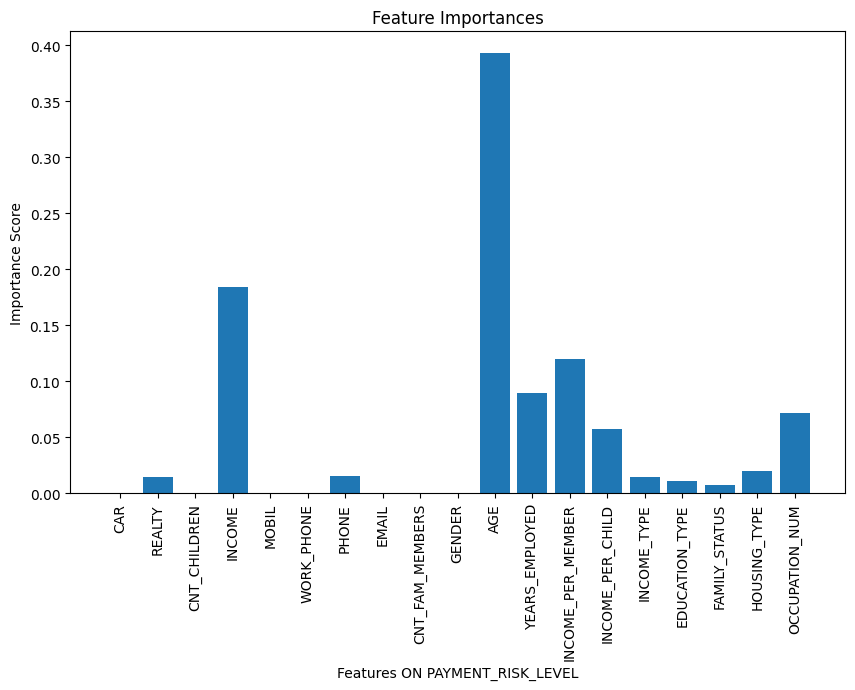

In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# Assuming you have the DataFrame 'df_merged' with the 'DEFAULT' column and other independent variables.

# Step 1: Prepare the Data
X = df_grouped_ID.drop(['DEFAULTED', 'STATUS_NUM', 'DEFAULT_FREQUENCY', 'CUST_STATUS_RISK','CUST_VALUE', 'CUST_SCORE', 'NUM_OF_RECORDS', 
                        'HISTORY_VALUE', 'HISTORY_LENGTH', 'HISTORY_RISK', 'BAD_PAYER', 'PAYMENT_RISK', 'LP_RATIO', 'PAYMENT_RISK_LEVEL', 'LATE_PAYMENT', 'TOTAL_HISTORY_LENGTH',
                        'DID_NOT_USE', 'PAID_ON_TIME', 'DNU_RATIO', 'POT_RATIO', 'NUM_RECORD_RISK', 'D_RATIO', 'ELP_RATIO', 'EXTREME_LATE_PAYMENT', 'NUM_OF_DEFAULTS'], axis=1)  # Independent variables (all columns except 'DEFAULT')
y = df_grouped_ID['PAYMENT_RISK_LEVEL']  # Target variable

# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Hyperparameter Tuning
param_dist = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

model = DecisionTreeClassifier(random_state=42)
grid_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Step 4: Get Feature Importances from the Best Model
feature_importances = best_model.feature_importances_

# Step 5: Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Features ON PAYMENT_RISK_LEVEL')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.show()


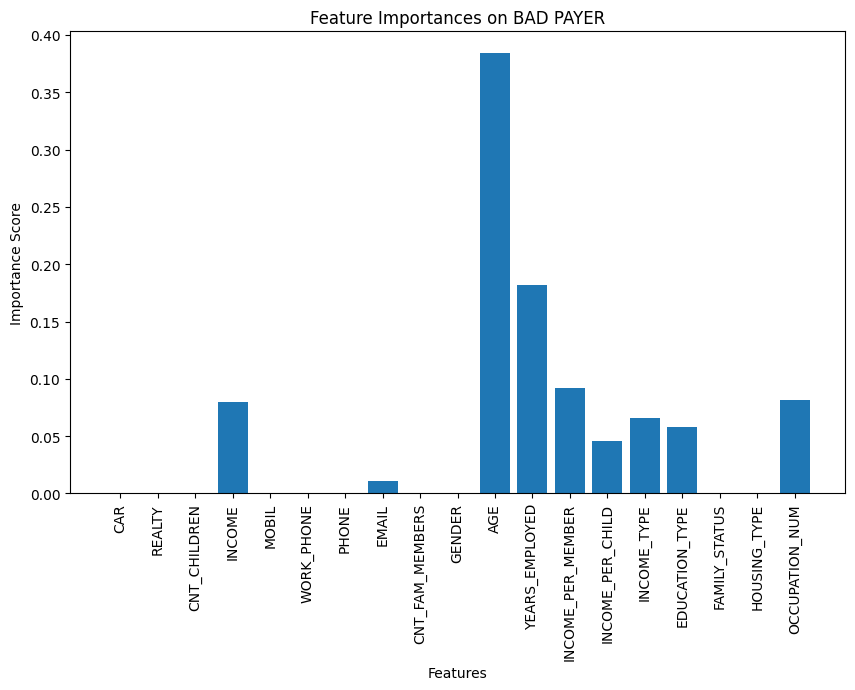

In [130]:
# Step 1: Prepare the Data
X = df_grouped_ID.drop(['DEFAULTED', 'STATUS_NUM', 'DEFAULT_FREQUENCY', 'CUST_STATUS_RISK', 'CUST_SCORE', 'CUST_VALUE', 
                        'BAD_PAYER', 'PAYMENT_RISK', 'LP_RATIO', 'PAYMENT_RISK_LEVEL', 'DNU_RATIO', 'POT_RATIO', 'ELP_RATIO', 
                        'D_RATIO', 'DID_NOT_USE', 'PAID_ON_TIME', 'LATE_PAYMENT', 'EXTREME_LATE_PAYMENT', 'NUM_OF_DEFAULTS',
                        'HISTORY_LENGTH', 'HISTORY_VALUE', 'NUM_OF_RECORDS', 'TOTAL_HISTORY_LENGTH', 'HISTORY_RISK', 'NUM_RECORD_RISK'], axis=1)  # Independent variables (all columns except 'DEFAULT')
y = df_grouped_ID['BAD_PAYER']  # Target variable

# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 3: Hyperparameter Tuning
param_dist = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

model = DecisionTreeClassifier(random_state=42)
grid_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Step 4: Get Feature Importances from the Best Model
feature_importances = best_model.feature_importances_

# Step 5: Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances on BAD PAYER')
plt.xticks(rotation=90)
plt.show()


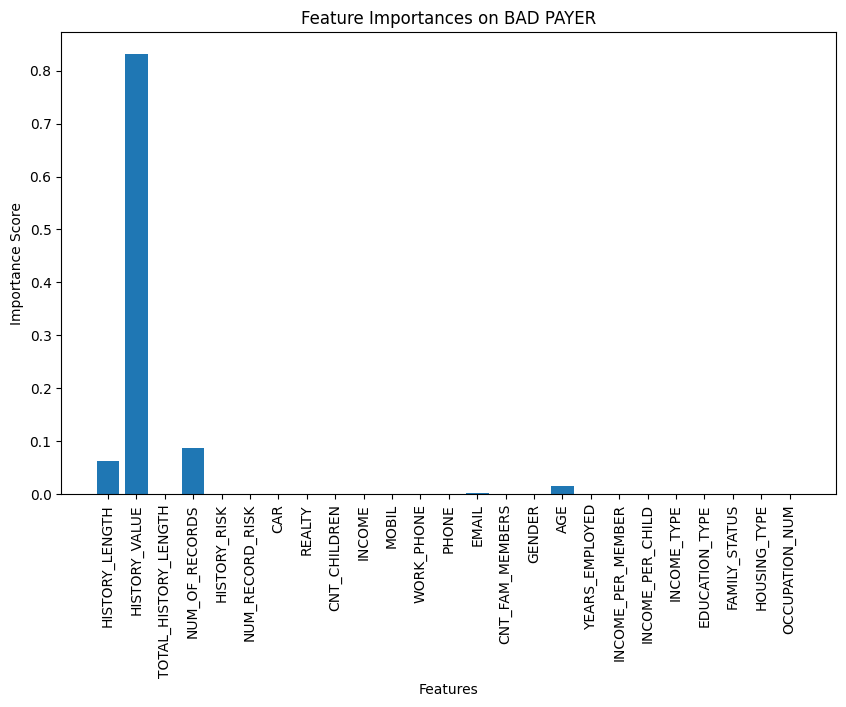

In [131]:
# Step 1: Prepare the Data
X = df_grouped_ID.drop(['DEFAULTED', 'STATUS_NUM', 'DEFAULT_FREQUENCY', 'CUST_STATUS_RISK', 'CUST_SCORE', 'CUST_VALUE', 
                        'BAD_PAYER', 'PAYMENT_RISK', 'LP_RATIO', 'PAYMENT_RISK_LEVEL', 'DNU_RATIO', 'POT_RATIO', 'ELP_RATIO', 
                        'D_RATIO', 'DID_NOT_USE', 'PAID_ON_TIME', 'LATE_PAYMENT', 'EXTREME_LATE_PAYMENT', 'NUM_OF_DEFAULTS'], axis=1)  # Independent variables (all columns except 'DEFAULT')
y = df_grouped_ID['BAD_PAYER']  # Target variable

# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 3: Hyperparameter Tuning
param_dist = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

model = DecisionTreeClassifier(random_state=42)
grid_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Step 4: Get Feature Importances from the Best Model
feature_importances = best_model.feature_importances_

# Step 5: Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances on BAD PAYER')
plt.xticks(rotation=90)
plt.show()

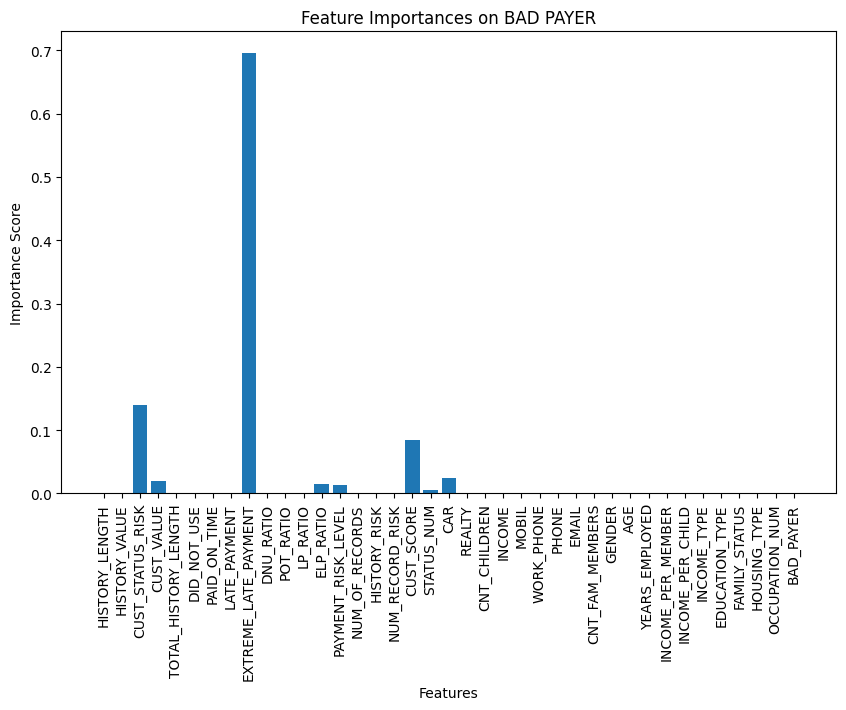

In [132]:
# Step 1: Prepare the Data
X = df_grouped_ID.drop(['DEFAULTED', 'D_RATIO', 'DEFAULT_FREQUENCY', 'NUM_OF_DEFAULTS', 'PAYMENT_RISK'], axis=1)  # Independent variables (all columns except 'DEFAULT')
y = df_grouped_ID['DEFAULTED']  # Target variable

# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 3: Hyperparameter Tuning
param_dist = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

model = DecisionTreeClassifier(random_state=42)
grid_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Step 4: Get Feature Importances from the Best Model
feature_importances = best_model.feature_importances_

# Step 5: Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances on BAD PAYER')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='DEFAULT_FREQUENCY', ylabel='INCOME'>

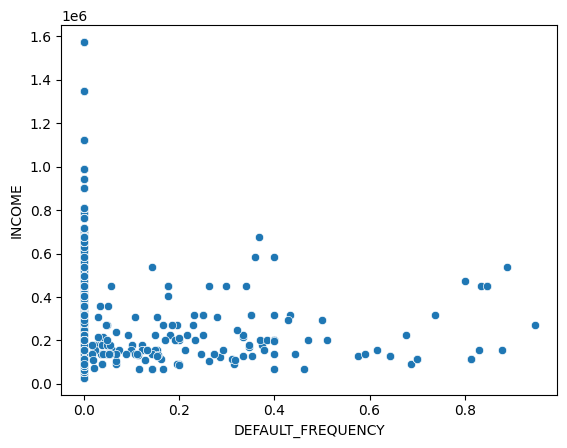

In [133]:
sns.scatterplot(x='DEFAULT_FREQUENCY', y='INCOME', data=df_grouped_ID)

In [134]:
correlations = df_grouped_ID.corrwith(df_grouped_ID['DEFAULT_FREQUENCY'])
print(correlations)

HISTORY_LENGTH          0.013208
DEFAULT_FREQUENCY       1.000000
HISTORY_VALUE           0.013079
CUST_STATUS_RISK        0.271185
CUST_VALUE             -0.059556
TOTAL_HISTORY_LENGTH    0.024293
DID_NOT_USE            -0.006752
PAID_ON_TIME           -0.021956
LATE_PAYMENT            0.008714
EXTREME_LATE_PAYMENT    0.426118
NUM_OF_DEFAULTS         0.858727
DNU_RATIO              -0.016726
POT_RATIO              -0.029772
LP_RATIO               -0.011635
ELP_RATIO               0.378015
D_RATIO                 0.948743
PAYMENT_RISK            0.405574
PAYMENT_RISK_LEVEL      0.240975
NUM_OF_RECORDS          0.032439
HISTORY_RISK           -0.020290
NUM_RECORD_RISK        -0.027608
CUST_SCORE             -0.073156
STATUS_NUM              0.271185
CAR                     0.006133
REALTY                 -0.000719
CNT_CHILDREN           -0.002326
INCOME                  0.018672
MOBIL                        NaN
WORK_PHONE             -0.001829
PHONE                   0.014483
EMAIL     

<Axes: xlabel='DEFAULTED', ylabel='NUM_OF_RECORDS'>

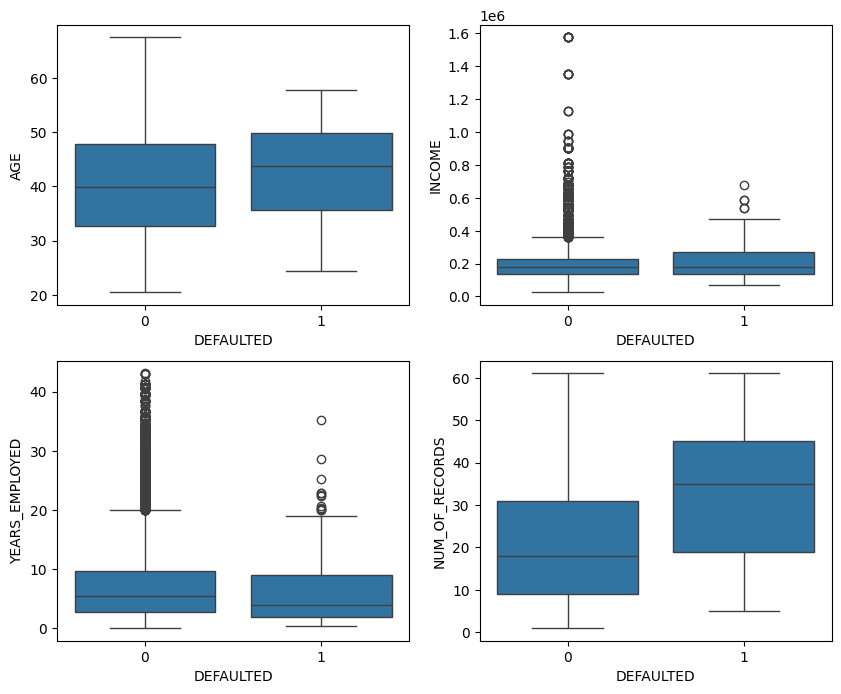

In [135]:
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(x='DEFAULTED',y='AGE', data=df_grouped_ID, ax=ax1)
sns.boxplot(x='DEFAULTED',y='INCOME', data=df_grouped_ID, ax=ax2)
sns.boxplot(x='DEFAULTED',y='YEARS_EMPLOYED', data=df_grouped_ID, ax=ax3)
sns.boxplot(x='DEFAULTED',y='NUM_OF_RECORDS', data=df_grouped_ID, ax=ax4)

In [136]:
df_merged

,ID,MONTHS_BALANCE,HISTORY_LENGTH,STATUS_VALUE,STATUS_RISK,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,...,GENDER,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM
0,5008804,0,1.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
1,5008804,-1,2.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
2,5008804,-2,3.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
3,5008804,-3,4.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
4,5008804,-4,5.0,2,1,0,1,1.125,2.125,16.0,...,1,32.89,12.44,213750.0,427500.0,4,1,0,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649575,5150487,-25,26.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4
649576,5150487,-26,27.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4
649577,5150487,-27,28.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4
649578,5150487,-28,29.0,2,1,0,4,1.000,2.000,30.0,...,1,53.15,5.93,101250.0,202500.0,4,4,1,1,4


In [137]:
df_merged['PAYMENT_RISK_LEVEL'].unique()

array([1, 2, 3, 5, 4, 7, 6])

<Axes: xlabel='STATUS_NUM', ylabel='NUM_OF_RECORDS'>

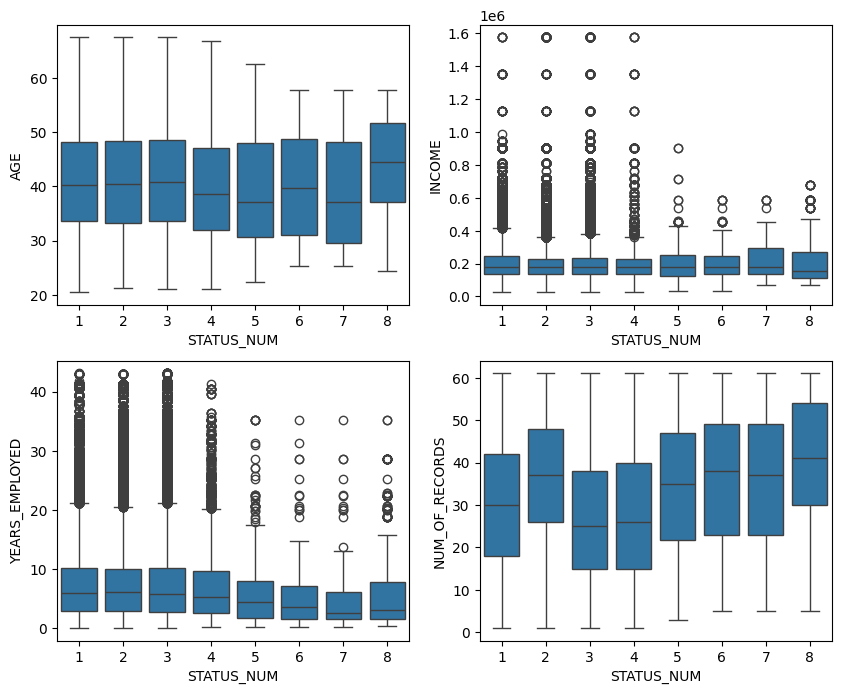

In [138]:
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(x='STATUS_NUM',y='AGE', data=df_merged, ax=ax1)
sns.boxplot(x='STATUS_NUM',y='INCOME', data=df_merged, ax=ax2)
sns.boxplot(x='STATUS_NUM',y='YEARS_EMPLOYED', data=df_merged, ax=ax3)
sns.boxplot(x='STATUS_NUM',y='NUM_OF_RECORDS', data=df_merged, ax=ax4)

In [139]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649580 entries, 0 to 649579
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    649580 non-null  int64  
 1   MONTHS_BALANCE        649580 non-null  int64  
 2   HISTORY_LENGTH        649580 non-null  float64
 3   STATUS_VALUE          649580 non-null  int64  
 4   STATUS_RISK           649580 non-null  int64  
 5   DEFAULT_FREQUENCY     649580 non-null  int64  
 6   HISTORY_VALUE         649580 non-null  int64  
 7   CUST_STATUS_RISK      649580 non-null  float64
 8   CUST_VALUE            649580 non-null  float64
 9   TOTAL_HISTORY_LENGTH  649580 non-null  float64
 10  DID_NOT_USE           649580 non-null  int64  
 11  PAID_ON_TIME          649580 non-null  int64  
 12  LATE_PAYMENT          649580 non-null  int64  
 13  EXTREME_LATE_PAYMENT  649580 non-null  int64  
 14  NUM_OF_DEFAULTS       649580 non-null  int64  
 15  

<Axes: xlabel='STATUS_NUM', ylabel='HISTORY_LENGTH'>

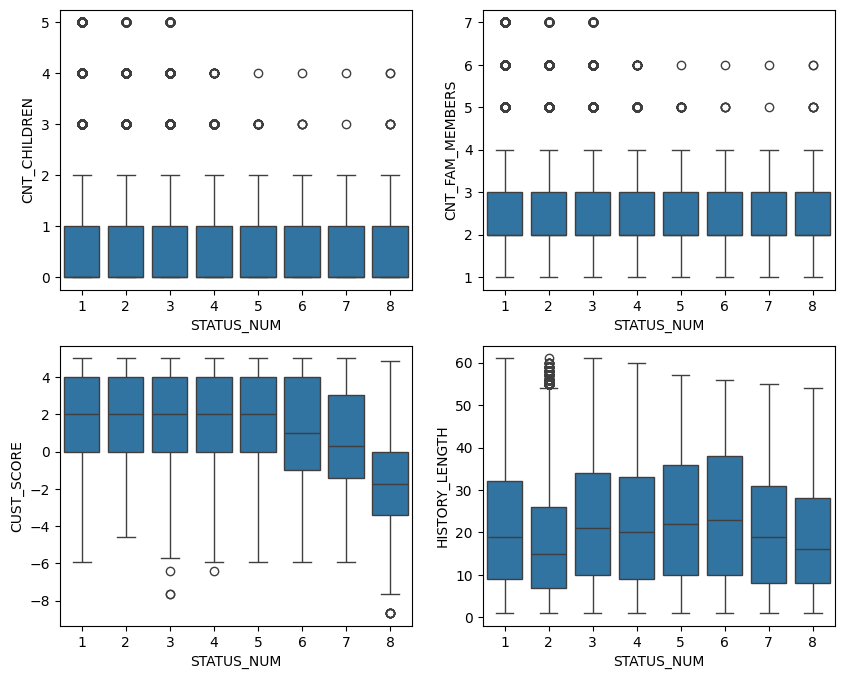

In [140]:
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(x='STATUS_NUM',y='CNT_CHILDREN', data=df_merged, ax=ax1)
sns.boxplot(x='STATUS_NUM',y='CNT_FAM_MEMBERS', data=df_merged, ax=ax2)
sns.boxplot(x='STATUS_NUM',y='CUST_SCORE', data=df_merged, ax=ax3)
sns.boxplot(x='STATUS_NUM',y='HISTORY_LENGTH', data=df_merged, ax=ax4)

In [141]:
df_grouped_ID.head()

,HISTORY_LENGTH,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,...,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM,DEFAULTED,BAD_PAYER
ID,,,,,,,,,,,,,,,,,,,,,
5008804,8.5,0.0,1.687500,1.125000,2.125000,16.0,1.0,13.0,2.0,0.0,...,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0,0,0
5008805,8.0,0.0,1.600000,1.133333,2.133333,15.0,1.0,12.0,2.0,0.0,...,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0,0,0
5008806,15.5,0.0,2.566667,0.700000,1.700000,30.0,16.0,7.0,7.0,0.0,...,3.11,56250.0,112500.0,4.0,4.0,1.0,1.0,16.0,0,0
5008808,3.0,0.0,1.000000,0.800000,1.800000,5.0,3.0,0.0,2.0,0.0,...,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0,0,0
5008809,25.0,0.0,4.000000,0.000000,1.000000,27.0,5.0,0.0,0.0,0.0,...,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0,0,0


In [142]:
df_grouped_ID.reset_index()

,ID,HISTORY_LENGTH,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,...,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM,DEFAULTED,BAD_PAYER
0,5008804,8.5,0.0,1.687500,1.125000,2.125000,16.0,1.0,13.0,2.0,...,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0,0,0
1,5008805,8.0,0.0,1.600000,1.133333,2.133333,15.0,1.0,12.0,2.0,...,12.44,213750.0,427500.0,4.0,1.0,0.0,4.0,18.0,0,0
2,5008806,15.5,0.0,2.566667,0.700000,1.700000,30.0,16.0,7.0,7.0,...,3.11,56250.0,112500.0,4.0,4.0,1.0,1.0,16.0,0,0
3,5008808,3.0,0.0,1.000000,0.800000,1.800000,5.0,3.0,0.0,2.0,...,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0,0,0
4,5008809,25.0,0.0,4.000000,0.000000,1.000000,27.0,5.0,0.0,0.0,...,8.36,270000.0,270000.0,0.0,4.0,3.0,1.0,14.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30311,5150482,20.5,0.0,3.222222,1.666667,2.666667,29.0,0.0,6.0,12.0,...,4.76,52500.0,78750.0,4.0,4.0,1.0,1.0,3.0,0,0
30312,5150483,9.5,0.0,1.833333,0.000000,1.000000,18.0,18.0,0.0,0.0,...,4.76,52500.0,78750.0,4.0,4.0,1.0,1.0,3.0,0,0
30313,5150484,7.0,0.0,1.461538,1.923077,2.923077,13.0,0.0,1.0,12.0,...,4.76,52500.0,78750.0,4.0,4.0,1.0,1.0,3.0,0,1
30314,5150485,1.5,0.0,1.000000,2.000000,3.000000,2.0,0.0,0.0,2.0,...,4.76,52500.0,78750.0,4.0,4.0,1.0,1.0,3.0,0,1


In [143]:
df_grouped_ID.describe(include='all')

,HISTORY_LENGTH,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,...,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM,DEFAULTED,BAD_PAYER
count,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,...,30316.000000,30316.000000,3.031600e+04,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000,30316.000000
mean,17.009797,0.001369,2.581366,1.302796,2.291841,27.223281,4.037439,9.049413,8.298522,0.012864,...,7.248585,101501.388014,1.547940e+05,2.680829,3.023090,1.316203,1.329661,9.466354,0.004915,0.217971
std,11.990784,0.025409,1.201035,0.618585,0.596464,16.445252,8.736029,13.031843,8.024469,0.175620,...,6.459157,74093.631066,1.008225e+05,1.771991,1.370116,0.893890,1.027823,5.536190,0.069935,0.412874
min,1.000000,0.000000,1.000000,0.000000,0.157895,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.050000,9000.000000,1.125000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.500000,0.000000,1.500000,1.064516,2.062500,13.000000,0.000000,0.000000,3.000000,0.000000,...,2.680000,54000.000000,8.100000e+04,0.000000,1.000000,1.000000,1.000000,4.000000,0.000000,0.000000
50%,14.500000,0.000000,2.464286,1.333333,2.333333,25.000000,1.000000,0.000000,6.000000,0.000000,...,5.460000,78750.000000,1.350000e+05,4.000000,4.000000,1.000000,1.000000,8.000000,0.000000,0.000000
75%,24.000000,0.000000,3.448980,1.766667,2.750000,40.000000,3.000000,15.000000,11.000000,0.000000,...,9.600000,126000.000000,2.025000e+05,4.000000,4.000000,1.000000,1.000000,14.000000,0.000000,0.000000
max,60.500000,0.947368,5.000000,6.736842,4.200000,61.000000,61.000000,58.000000,61.000000,7.000000,...,43.050000,900000.000000,1.350000e+06,4.000000,4.000000,4.000000,5.000000,18.000000,1.000000,1.000000


In [144]:
df_grouped_ID.groupby('DEFAULTED').count()

,HISTORY_LENGTH,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,...,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM,BAD_PAYER
DEFAULTED,,,,,,,,,,,,,,,,,,,,,
0,30167,30167,30167,30167,30167,30167,30167,30167,30167,30167,...,30167,30167,30167,30167,30167,30167,30167,30167,30167,30167
1,149,149,149,149,149,149,149,149,149,149,...,149,149,149,149,149,149,149,149,149,149


In [145]:
df_grouped_ID.groupby('BAD_PAYER').count()

,HISTORY_LENGTH,DEFAULT_FREQUENCY,HISTORY_VALUE,CUST_STATUS_RISK,CUST_VALUE,TOTAL_HISTORY_LENGTH,DID_NOT_USE,PAID_ON_TIME,LATE_PAYMENT,EXTREME_LATE_PAYMENT,...,AGE,YEARS_EMPLOYED,INCOME_PER_MEMBER,INCOME_PER_CHILD,INCOME_TYPE,EDUCATION_TYPE,FAMILY_STATUS,HOUSING_TYPE,OCCUPATION_NUM,DEFAULTED
BAD_PAYER,,,,,,,,,,,,,,,,,,,,,
0,23708,23708,23708,23708,23708,23708,23708,23708,23708,23708,...,23708,23708,23708,23708,23708,23708,23708,23708,23708,23708
1,6608,6608,6608,6608,6608,6608,6608,6608,6608,6608,...,6608,6608,6608,6608,6608,6608,6608,6608,6608,6608


In [146]:
# Set the option to display all columns without truncation
pd.set_option('display.max_columns', None)

# Display the information about the DataFrame
df_grouped_ID.info()

# Reset the option to the default
pd.reset_option('display.max_columns')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30316 entries, 5008804 to 5150487
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HISTORY_LENGTH        30316 non-null  float64
 1   DEFAULT_FREQUENCY     30316 non-null  float64
 2   HISTORY_VALUE         30316 non-null  float64
 3   CUST_STATUS_RISK      30316 non-null  float64
 4   CUST_VALUE            30316 non-null  float64
 5   TOTAL_HISTORY_LENGTH  30316 non-null  float64
 6   DID_NOT_USE           30316 non-null  float64
 7   PAID_ON_TIME          30316 non-null  float64
 8   LATE_PAYMENT          30316 non-null  float64
 9   EXTREME_LATE_PAYMENT  30316 non-null  float64
 10  NUM_OF_DEFAULTS       30316 non-null  float64
 11  DNU_RATIO             30316 non-null  float64
 12  POT_RATIO             30316 non-null  float64
 13  LP_RATIO              30316 non-null  float64
 14  ELP_RATIO             30316 non-null  float64
 15  D_RATIO    

In [147]:
# Display the information about columns 20 to 40 in the DataFrame
df_grouped_ID.iloc[:, 20:40].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30316 entries, 5008804 to 5150487
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUM_RECORD_RISK    30316 non-null  float64
 1   CUST_SCORE         30316 non-null  float64
 2   STATUS_NUM         30316 non-null  float64
 3   CAR                30316 non-null  float64
 4   REALTY             30316 non-null  float64
 5   CNT_CHILDREN       30316 non-null  float64
 6   INCOME             30316 non-null  float64
 7   MOBIL              30316 non-null  float64
 8   WORK_PHONE         30316 non-null  float64
 9   PHONE              30316 non-null  float64
 10  EMAIL              30316 non-null  float64
 11  CNT_FAM_MEMBERS    30316 non-null  float64
 12  GENDER             30316 non-null  float64
 13  AGE                30316 non-null  float64
 14  YEARS_EMPLOYED     30316 non-null  float64
 15  INCOME_PER_MEMBER  30316 non-null  float64
 16  INCOME_PER_CHI

In [148]:
df_grouped_ID['PAYMENT_RISK_LEVEL'].unique()

array([1., 2., 3., 5., 4., 7., 6.])

In [149]:
df_grouped_ID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30316 entries, 5008804 to 5150487
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HISTORY_LENGTH        30316 non-null  float64
 1   DEFAULT_FREQUENCY     30316 non-null  float64
 2   HISTORY_VALUE         30316 non-null  float64
 3   CUST_STATUS_RISK      30316 non-null  float64
 4   CUST_VALUE            30316 non-null  float64
 5   TOTAL_HISTORY_LENGTH  30316 non-null  float64
 6   DID_NOT_USE           30316 non-null  float64
 7   PAID_ON_TIME          30316 non-null  float64
 8   LATE_PAYMENT          30316 non-null  float64
 9   EXTREME_LATE_PAYMENT  30316 non-null  float64
 10  NUM_OF_DEFAULTS       30316 non-null  float64
 11  DNU_RATIO             30316 non-null  float64
 12  POT_RATIO             30316 non-null  float64
 13  LP_RATIO              30316 non-null  float64
 14  ELP_RATIO             30316 non-null  float64
 15  D_RATIO    

In [150]:
df_grouped_ID.reset_index

<bound method DataFrame.reset_index of          HISTORY_LENGTH  DEFAULT_FREQUENCY  HISTORY_VALUE  CUST_STATUS_RISK  \
ID                                                                            
5008804             8.5                0.0       1.687500          1.125000   
5008805             8.0                0.0       1.600000          1.133333   
5008806            15.5                0.0       2.566667          0.700000   
5008808             3.0                0.0       1.000000          0.800000   
5008809            25.0                0.0       4.000000          0.000000   
...                 ...                ...            ...               ...   
5150482            20.5                0.0       3.222222          1.666667   
5150483             9.5                0.0       1.833333          0.000000   
5150484             7.0                0.0       1.461538          1.923077   
5150485             1.5                0.0       1.000000          2.000000   
5150487      

# Define the target variable

- using payment risk level to generate a target variable approve
- 1: approve: low risk of payment
- 0: reject: high risk of payment

In [151]:
df_grouped_ID['APPROVE'] = df_grouped_ID['PAYMENT_RISK_LEVEL'].replace({1: 1, 2: 1, 3: 0, 4: 0, 5:0, 6:0, 7:0})

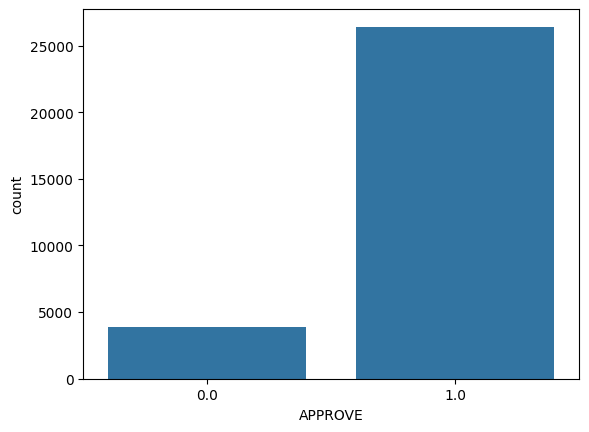

In [152]:
sns.countplot(x='APPROVE', data=df_grouped_ID)
plt.show()

# Model Development

Pipeline

In [153]:
X = df_grouped_ID[['AGE', 'YEARS_EMPLOYED', 'INCOME_PER_MEMBER','INCOME_TYPE', 'EDUCATION_TYPE', 'OCCUPATION_NUM', 'INCOME','PHONE','HOUSING_TYPE','REALTY','CAR']]
y = df_grouped_ID['APPROVE']

Using Synthetic Minority Over-Sampling Technique(SMOTE) to overcome sample imbalance problem.

In [154]:
pip install imblearn

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Assuming you have already defined X and y
y = y.astype('int')

# Instantiate SMOTE and apply it to your data
smote = SMOTE()
X_balance, Y_balance = smote.fit_resample(X, y)

# Convert the balanced data back to a DataFrame
X_balance = pd.DataFrame(X_balance, columns=X.columns)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

- Model selection: use all the classification models: decision tree, KNN, logitic regression, GNB to find the best. 
- Using hyperparameter to choose best parameter, using cross validation to test overfitting
- Evaluation: use 'precision' as key metric, since we dont want to approve right clients (1-approve).

Decision Tree

In [ ]:
#hyperparameter
param_grid = {
    'max_depth': [3, 6, 9],            # Depth of the decision tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3]      # Minimum number of samples required to be at a leaf node
}

# Create the Decision Tree classifier
model = DecisionTreeClassifier(random_state=1024, class_weight='balanced')

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)
# random search
random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='recall')
random_search.fit(X_train, y_train)

# Get the best parameters!
print("Best parameters for gridsearch: ", grid_search.best_params_)
print("Best parameters for randomsearch: ", random_search.best_params_)

Best parameters for gridsearch:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for randomsearch:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 6}


In [ ]:
# Get the best model
best_model = random_search.best_estimator_

# Perform cross-validation on the best model
cv_scores_tree = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')

print("Cross-validation scores for decision tree: ", cv_scores_tree)

# Make predictions on the test set using the best model
y_pred_tree = best_model.predict(X_test)

Cross-validation scores for decision tree:  [0.98729386 0.99161709 0.97620335 0.99161936 0.99161936]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      7926
           1       0.69      0.98      0.81      7926

    accuracy                           0.78     15852
   macro avg       0.83      0.78      0.77     15852
weighted avg       0.83      0.78      0.77     15852



In [ ]:
print("DecisionTreeClassifier Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_tree))
print("Accuracy: ", accuracy_score(y_test, y_pred_tree))
print("F1_score: ", f1_score(y_test, y_pred_tree))
print("Precision: ", precision_score(y_test, y_pred_tree))
print("Recall: ", recall_score(y_test, y_pred_tree))

DecisionTreeClassifier Metrics: 
Confusion Matrix:  [[4496 3430]
 [ 120 7806]]
Accuracy:  0.7760534948271511
F1_score:  0.8147375013046656
Precision:  0.6947312210751156
Recall:  0.9848599545798638


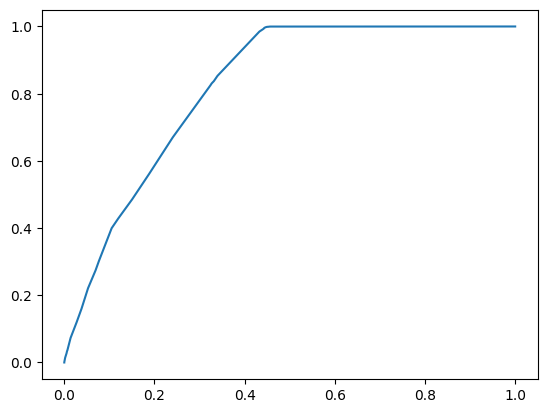

In [ ]:
fpr, tpr, tresholds = roc_curve(y_test,best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr)

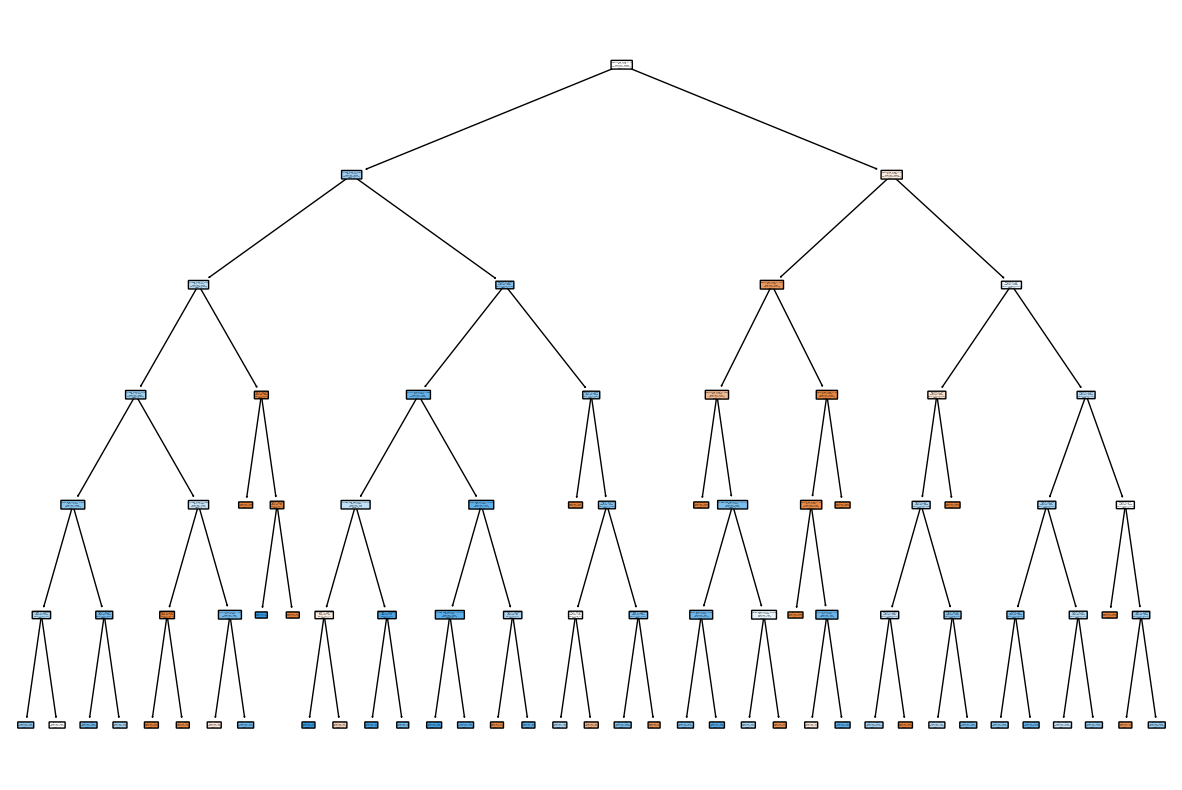

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get the feature names
feature_names = X_train.columns

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(best_model, filled=True, feature_names=feature_names, class_names=['0', '1'], rounded=True)
plt.show()

KNN

In [ ]:
# Hyperparameter tuning
params_knn = {'n_neighbors': list(range(1,100)), 'weights': ['uniform', 'distance'], 'metric':['euclidean','manhattan','minkowski','chebyshev']}

# Define the models
knn = KNeighborsClassifier()

# Define GridSearchCV, RandomizedSearchCV
gridsearch_knn = GridSearchCV(knn, params_knn, cv=3, scoring='recall') #for the risk analysis, accuracy is better
    #nb, params_nb, cv=5)
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=3, n_iter = 5, scoring='recall') 

# Fit models
gridsearch_knn.fit(X_train, y_train)
randomsearch_knn.fit(X_train, y_train)

# Get the best parameters!
print("Best parameters for gridsearch_knn: ", gridsearch_knn.best_params_)
print("Best parameters for randomsearch_knn: ", randomsearch_knn.best_params_)

Best parameters for gridsearch_knn:  {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best parameters for randomsearch_knn:  {'weights': 'distance', 'n_neighbors': 26, 'metric': 'manhattan'}


In [ ]:
# Apply the best parameters
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)

# Perform cross-validation
cv_scores_knn = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='recall')
print("Cross-validation scores for KNN: ", cv_scores_knn)

# Fit the models with the best parameters
knn_best.fit(X_train, y_train)

# Evaluate on the test set
y_pred_knn = knn_best.predict(X_test) 


Cross-validation scores for KNN:  [0.80670451 0.82639264 0.80475933 0.81643687 0.81157069]


No overfitting

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      7926
           1       0.80      0.84      0.82      7926

    accuracy                           0.81     15852
   macro avg       0.81      0.81      0.81     15852
weighted avg       0.81      0.81      0.81     15852



In [ ]:
print("\nK-Nearest Neighbors Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_knn))
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("F1_score: ", f1_score(y_test, y_pred_knn))
print("Precision: ", precision_score(y_test, y_pred_knn))
print("Recall: ", recall_score(y_test, y_pred_knn))


K-Nearest Neighbors Metrics: 
Confusion Matrix:  [[6233 1693]
 [1266 6660]]
Accuracy:  0.8133358566742367
F1_score:  0.8182320781374777
Precision:  0.7973183287441638
Recall:  0.8402725208175624


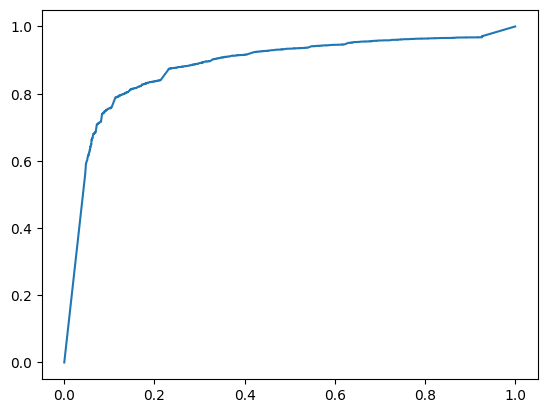

In [ ]:
fpr, tpr, tresholds = roc_curve(y_test,knn_best.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr)

Logistic Regression

In [ ]:
# Create the Logistic Regression classifier
model = LogisticRegression(random_state=1024,class_weight='balanced')

# Define the hyperparameter grid for tuning
param_grid = {
    'penalty': ['l2'],                 # Regularization penalty ('l2' for L2 regularization)
    'C': [0.1, 1, 10],                 # Inverse of regularization strength (smaller values specify stronger regularization)
    'solver': ['liblinear', 'lbfgs']   # Optimization algorithm
}

# Perform grid search with recall as the scoring metric and cross-validation
random_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='recall')
random_search.fit(X_train, y_train)

# Get the best model
best_model =random_search.best_estimator_

# Perform cross-validation on the best model
cv_scores_logreg = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')

print("Cross-validation scores for logistic regression: ", cv_scores_logreg)

# Make predictions on the test set using the best model
y_pred_logreg = best_model.predict(X_test)

/Users/junboli/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Cross-validation scores for logistic regression:  [0.82589889 0.83802055 0.82206598 0.32711544 0.83427954]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.19      0.28      7926
           1       0.51      0.84      0.63      7926

    accuracy                           0.52     15852
   macro avg       0.53      0.52      0.46     15852
weighted avg       0.53      0.52      0.46     15852



In [ ]:
print("LogisticRegression Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_logreg))
print("Accuracy: ", accuracy_score(y_test, y_pred_logreg))
print("F1_score: ", f1_score(y_test, y_pred_logreg))
print("Precision: ", precision_score(y_test, y_pred_logreg))
print("Recall: ", recall_score(y_test, y_pred_logreg))

LogisticRegression Metrics: 
Confusion Matrix:  [[1524 6402]
 [1274 6652]]
Accuracy:  0.5157708806459753
F1_score:  0.6341277407054338
Precision:  0.509575609008733
Recall:  0.8392631844562201


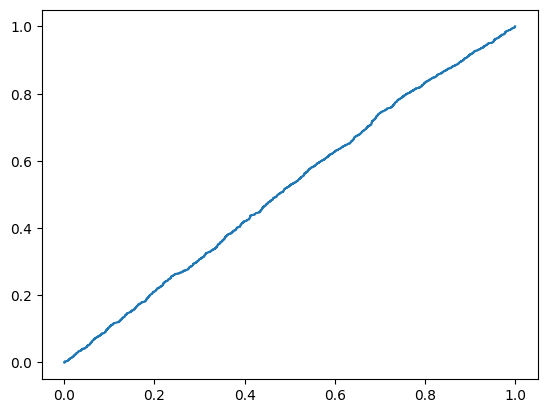

In [ ]:
fpr, tpr, tresholds = roc_curve(y_test,best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr)

Nive Bayes

In [ ]:
# Create the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the hyperparameter grid for tuning
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]  # Regularization parameter to stabilize computation (variance smoothing)
}

# Perform grid search with recall as the scoring metric and cross-validation
grid_search = GridSearchCV(gnb, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Perform cross-validation on the best model
cv_scores_nb = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')

print("Cross-validation scores for Gaussian Naive Bayes: ", cv_scores_nb)

# Make predictions on the test set using the best model
y_pred_gnb = best_model.predict(X_test)

Cross-validation scores for Gaussian Naive Bayes:  [0.80805623 0.796106   0.67550027 0.80481211 0.792917  ]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_gnb))

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.21      0.30      7926
           1       0.50      0.80      0.62      7926

    accuracy                           0.51     15852
   macro avg       0.51      0.51      0.46     15852
weighted avg       0.51      0.51      0.46     15852



In [ ]:
print("GaussianNB Metrics: ")
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred_gnb))
print("Accuracy: ", accuracy_score(y_test, y_pred_gnb))
print("F1_score: ", f1_score(y_test, y_pred_gnb))
print("Precision: ", precision_score(y_test, y_pred_gnb))
print("Recall: ", recall_score(y_test, y_pred_gnb))

GaussianNB Metrics: 
Confusion Matrix:  [[1662 6264]
 [1578 6348]]
Accuracy:  0.5052990158970477
F1_score:  0.6181711948583115
Precision:  0.5033301617507137
Recall:  0.8009084027252081


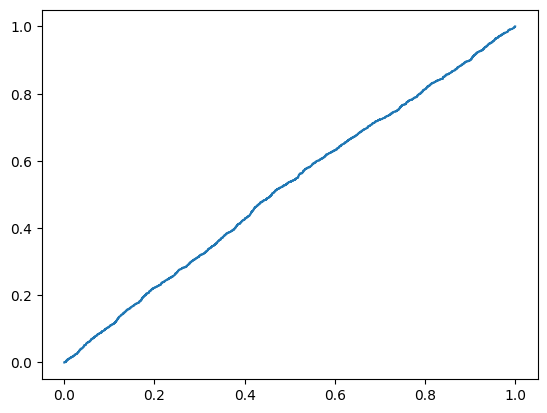

In [ ]:
fpr, tpr, tresholds = roc_curve(y_test,best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr)

KNN performed best in precision and other metric, so we select KNN as our final model